## Segmentando a forma de um objeto em uma imagem
***

Esse algoritmo é muito parecido com o de HuMoments, porém é mais avançado e gera um resultado final mais preciso, porém mais complexo.

Utiliza como cálculos matemáticos funções ortogonais.

Semelhante aos Momentos de Hu, podemos usar Zernike Moments para caracterizar e quantificar a forma de um objeto em uma imagem. Igualmente parecido com Hu Moments, a forma de uma imagem que desejamos descrever pode ser o contorno (isto é, "limite") da forma ou uma máscara (isto é, "limite preenchido") da forma que queremos descrever. 

Na maioria das aplicações do mundo real, é comum usar a máscara de forma, pois é menos suscetível ao ruído. No entanto, ao contrário de Hu Moments, Zernike Moments são descritores de imagens mais poderosos e geralmente mais precisos, com muito pouco custo computacional adicional. Zernike Moments é um descritor de imagem usado para caracterizar a forma de um objeto em uma imagem. A forma a ser descrita pode ser uma imagem binária segmentada ou o limite do objeto (isto é, o "contorno" da forma).

Para utilizar e extrair Zernike Momentos, estaremos usando o pacote de mahotas. Zernike Moments não está disponível no OpenCV.

***
### Instalação
***

Além do OpenCV para usar esse algoritmo precisamos baixas o pacote **mahotas**.

```
sudo apt-get install build-essential autoconf libtool pkg-config python-opengl python-imaging python-pyrex python-pyside.qtopengl idle-python2.7 qt4-dev-tools qt4-designer libqtgui4 libqtcore4 libqt4-xml libqt4-test libqt4-script libqt4-network libqt4-dbus python-qt4 python-qt4-gl libgle3 python-dev
```

```py
pip3 install mahotas
```

***

In [1]:
# Imports
import numpy as np
from scipy.spatial import distance as dist
from matplotlib import pyplot as plt
import cv2
import mahotas

def show(img, title=""):
    """
    Redimensionar a imagem e mostrar no codigo.
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.title(title, fontdict={"fontsize": 100})
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
def describe_shapes(image):
    # Inicializa a lista de features de shapes
    shapeFeatures = []

    # Converte para Grayscale e threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show(gray, "Escala de Cinza")
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    show(blurred, "Suavizar")
    thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]
    show(thresh, "Binarizar")

    # Realiza uma série de dilatações e erosões para fechar furos nas formas
    thresh = cv2.dilate(thresh, None, iterations=4)
    show(thresh, "Remover furos com dilatação")
    thresh = cv2.erode(thresh, None, iterations=2)
    show(thresh, "Remover furos com erosão")

    # Detecta contornos no mapa de borda
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop pelos contornos
    for c in cnts:
        # Cria uma máscara vazia para o contorno, e desenha
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # Extrai o ROI da caixa delimitadora da máscara
        (x, y, w, h) = cv2.boundingRect(c)
        roi = mask[y:y + h, x:x + w]

        # Computa Zernike Moments para o ROI e atualiza a lista de recursos de shape
        features = mahotas.features.zernike_moments(roi, cv2.minEnclosingCircle(c)[1], degree=8)
        shapeFeatures.append(features)

    # Retorna uma tupla dos contornos e shapes
    return (cnts, shapeFeatures)

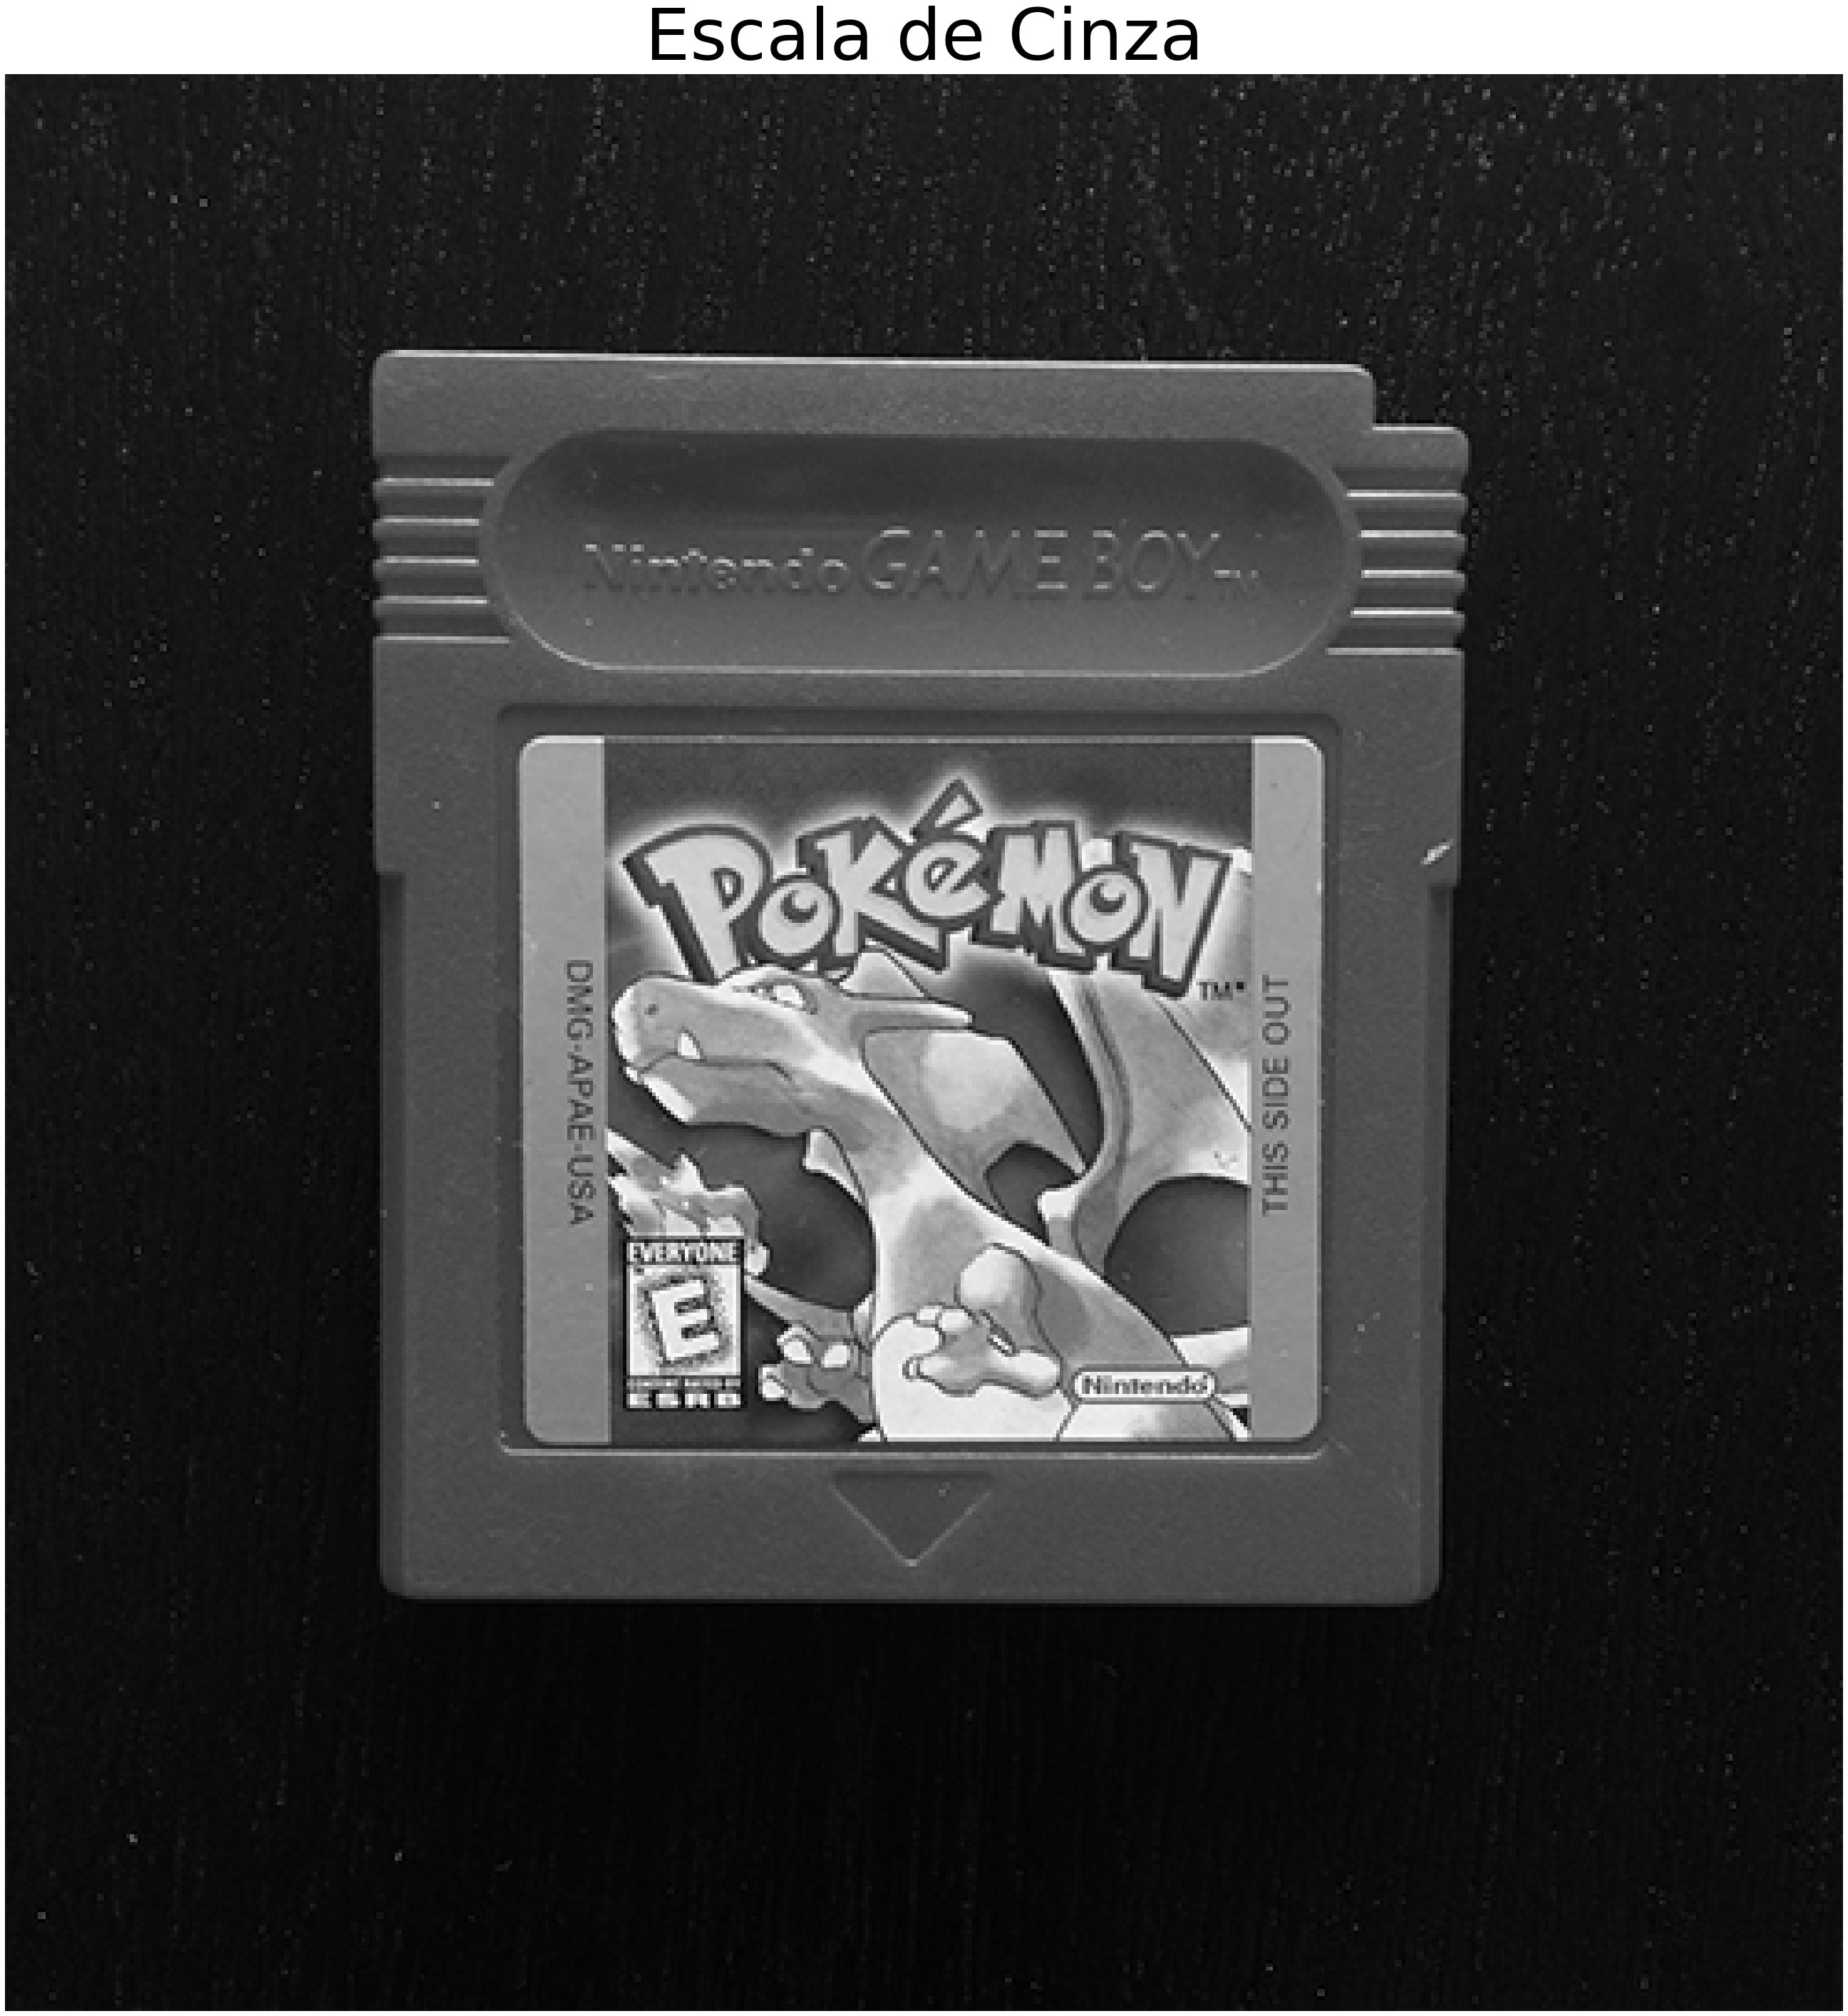

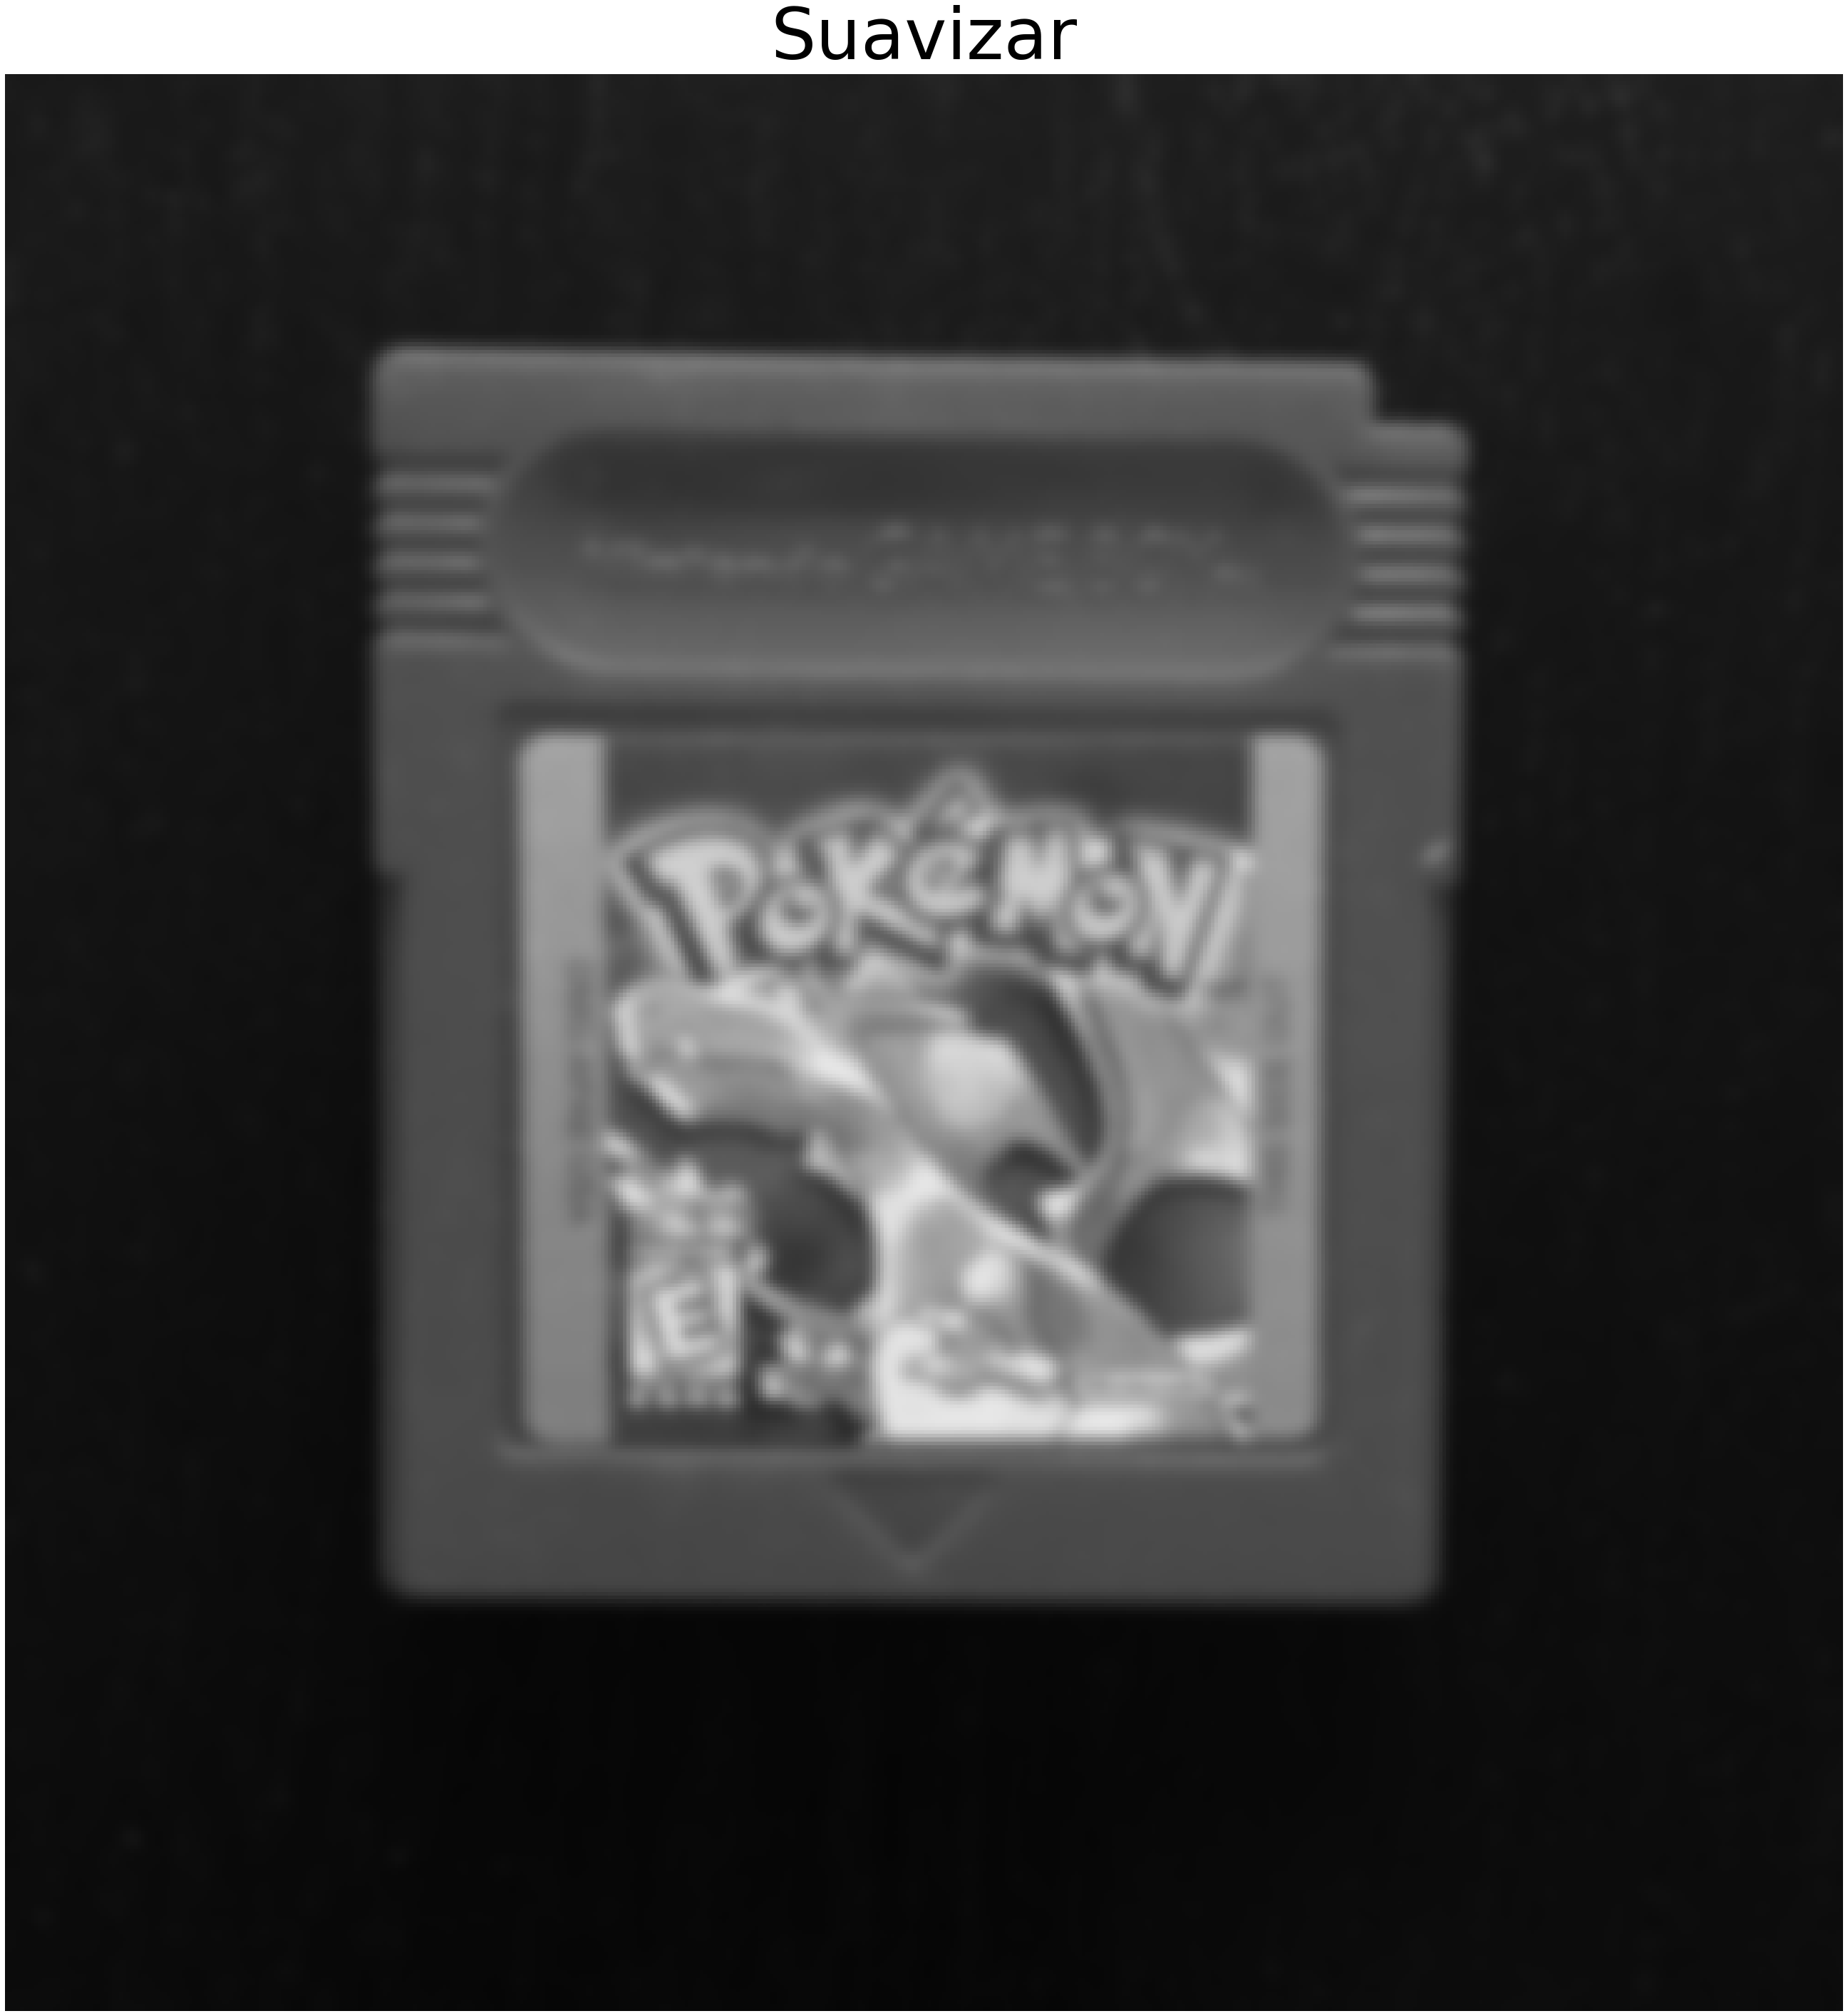

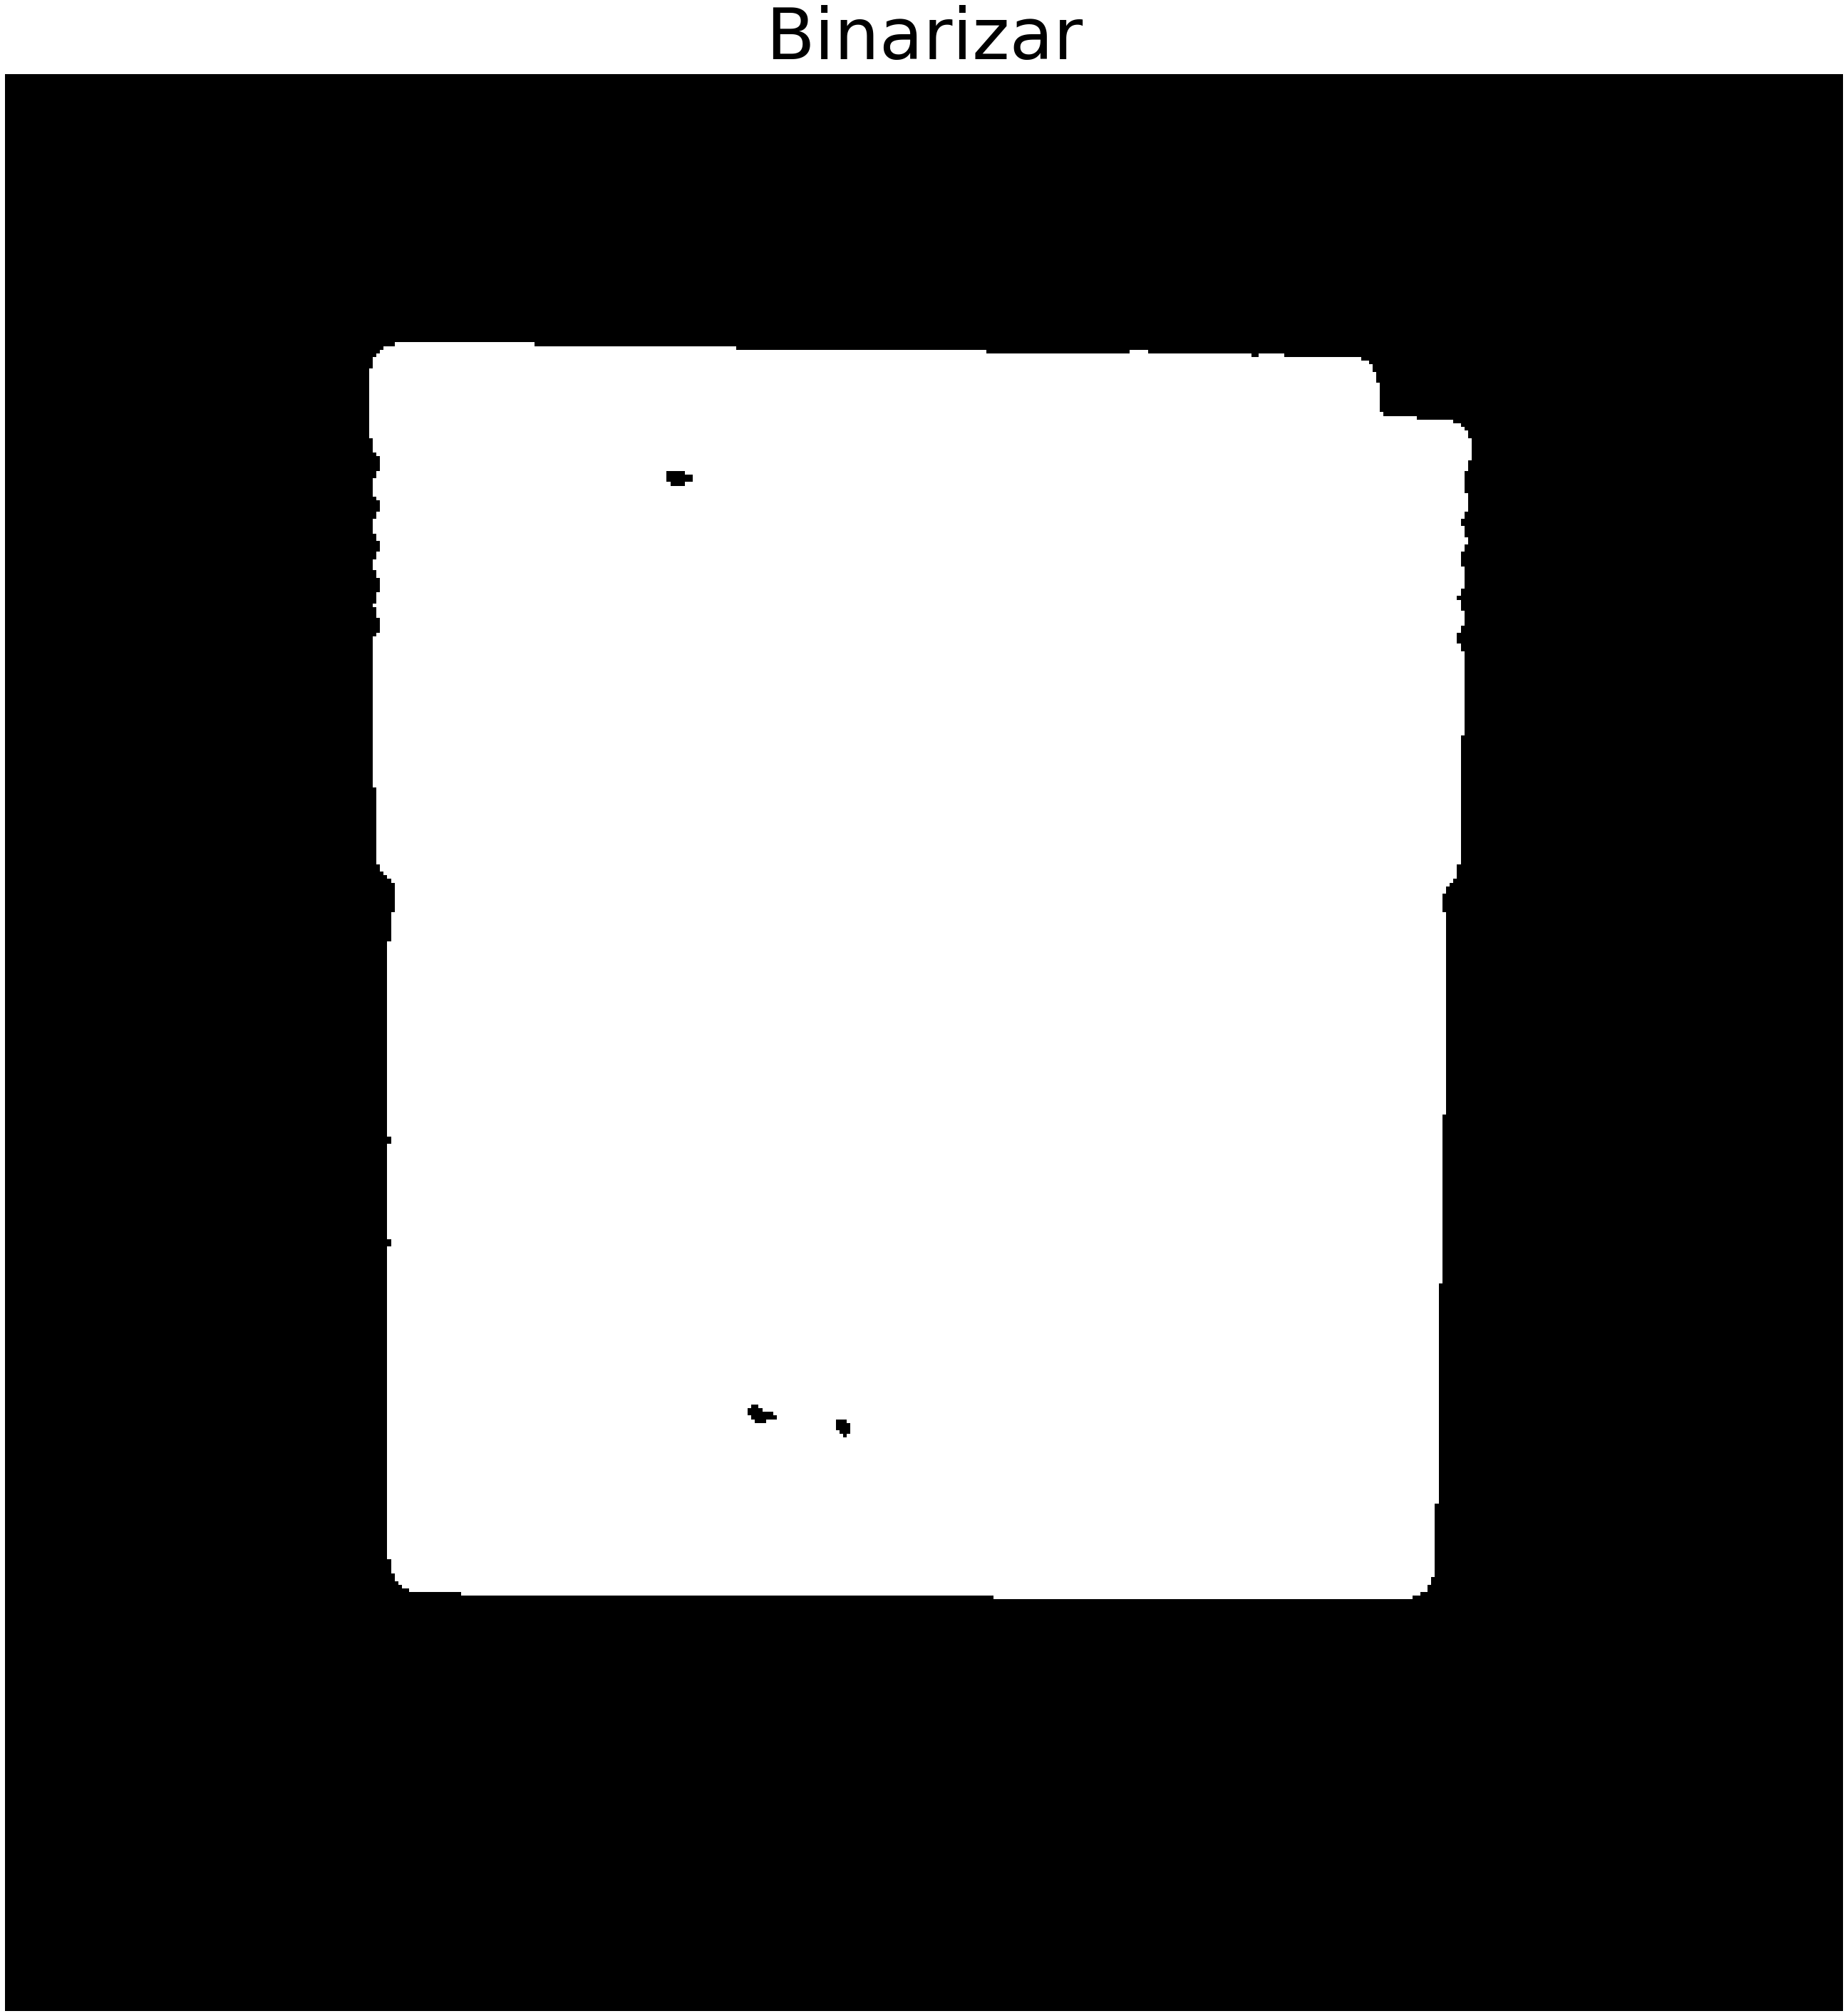

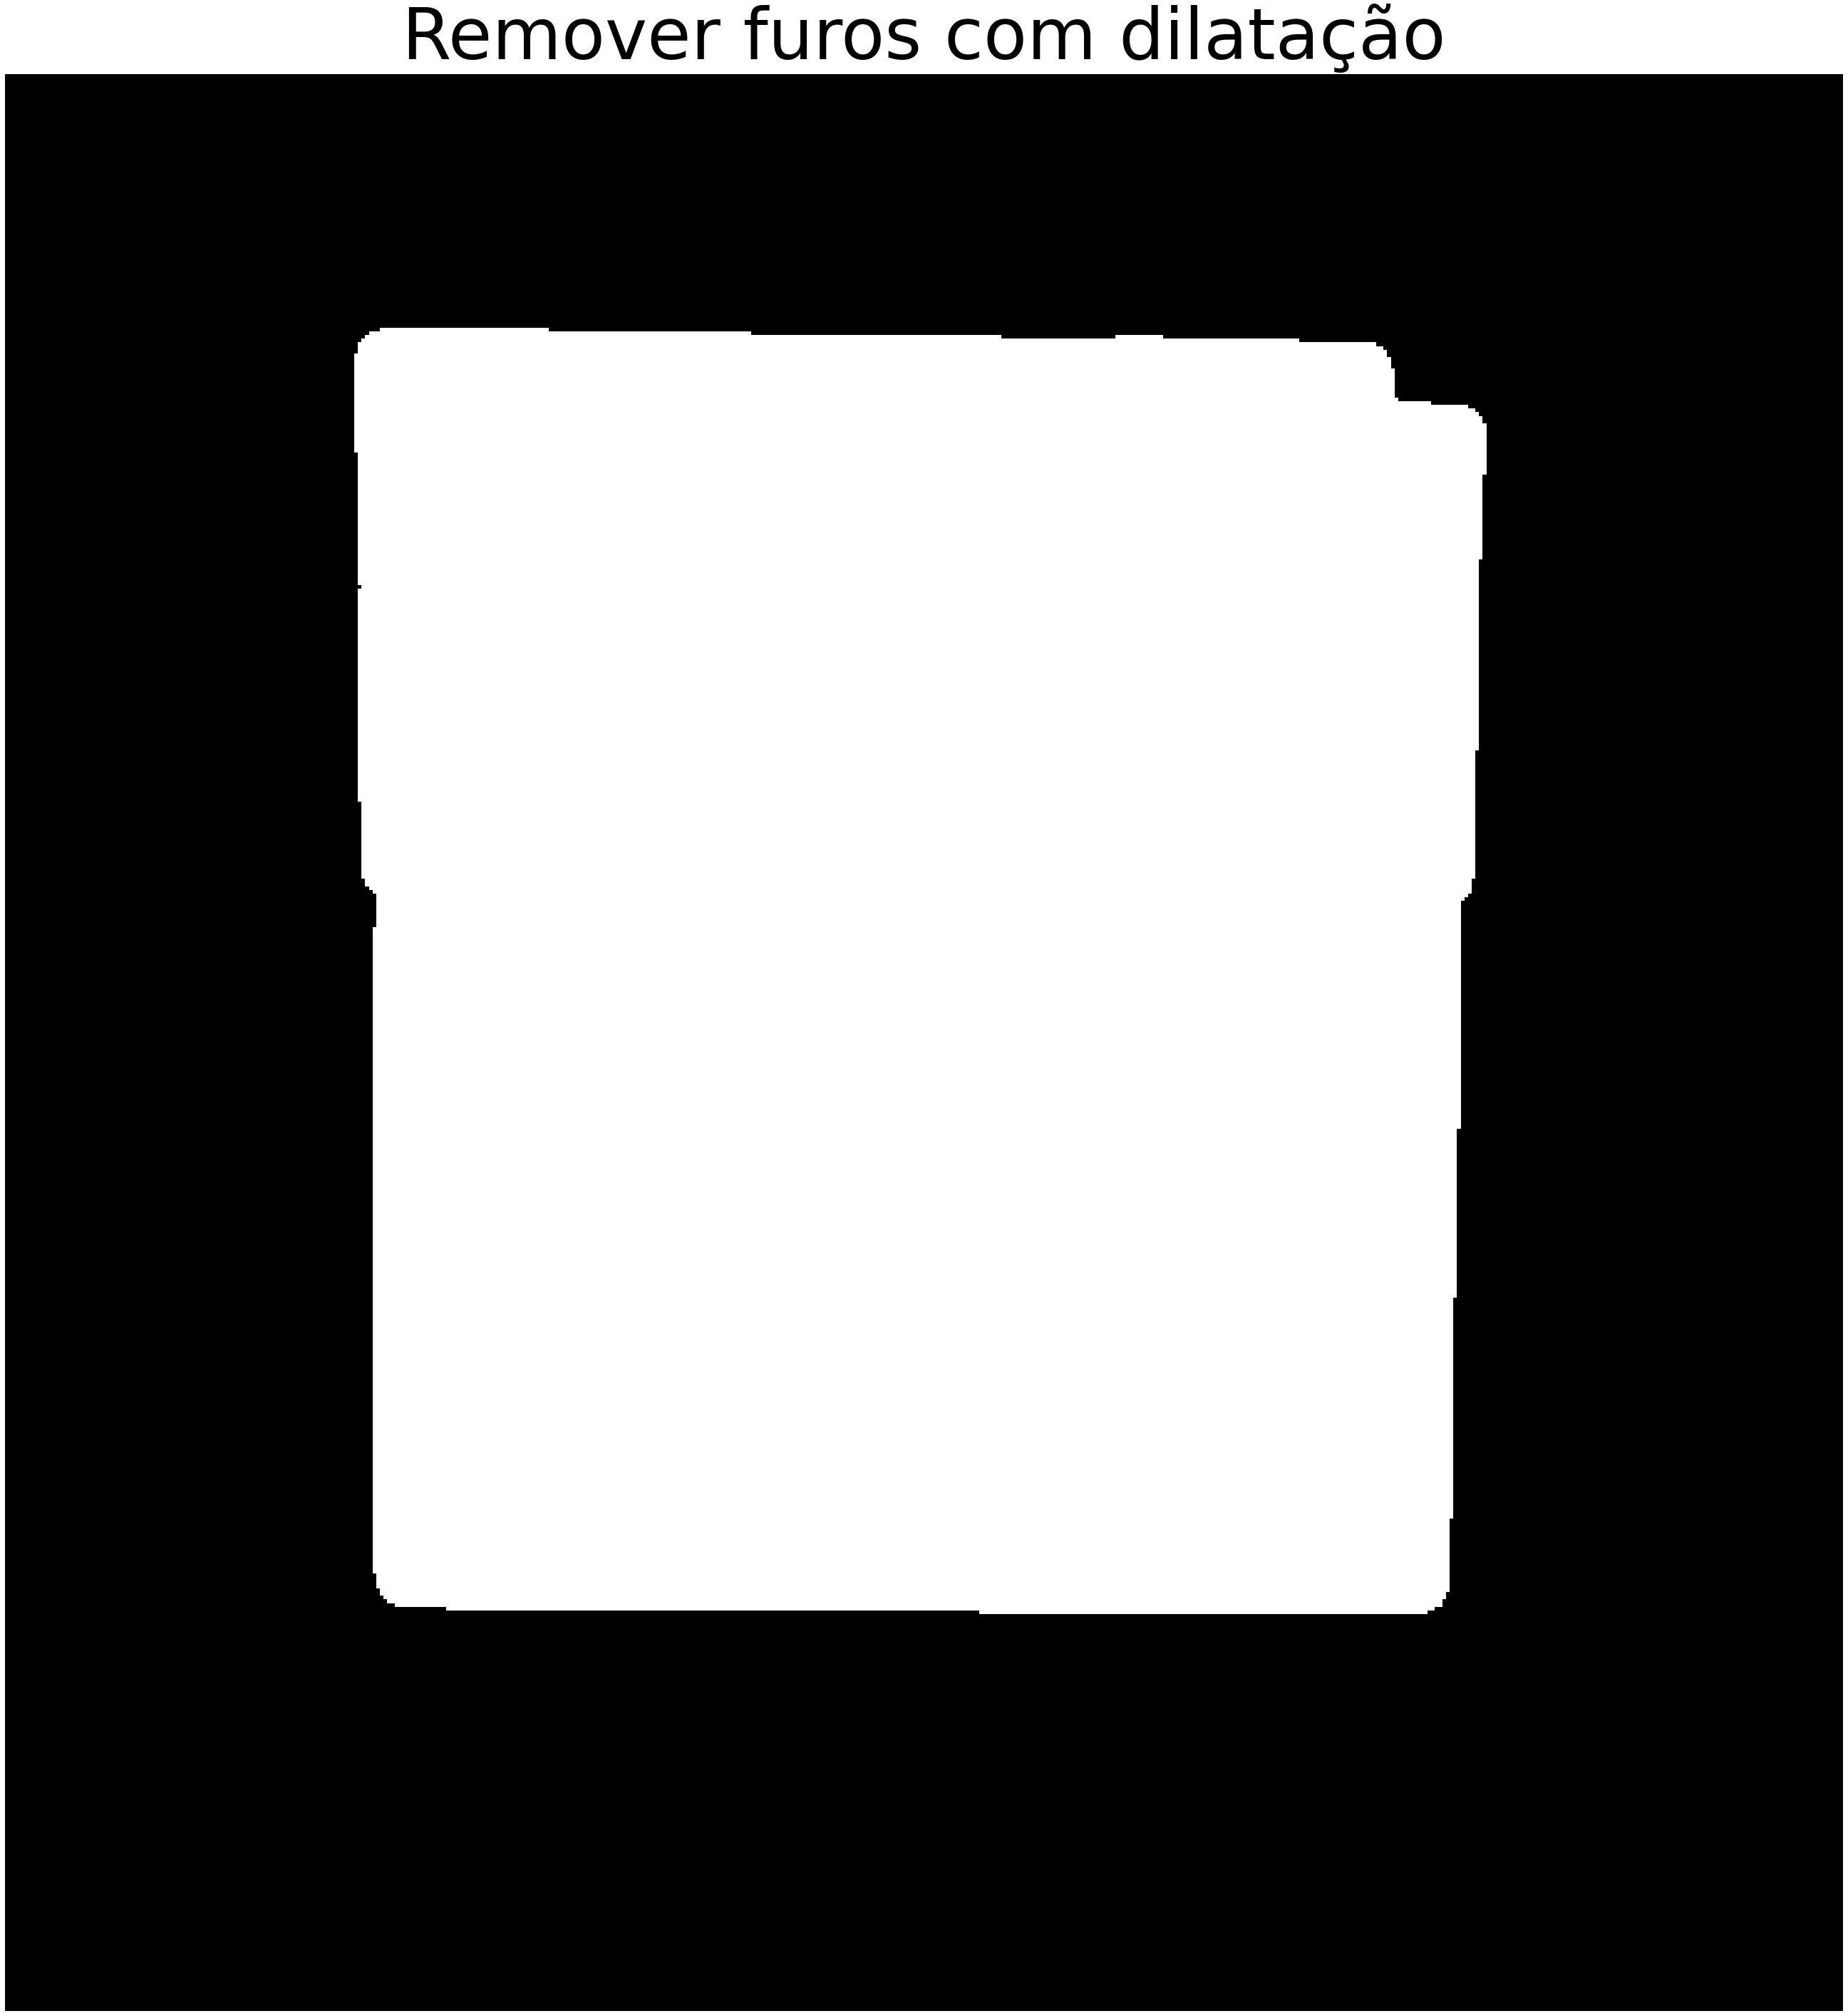

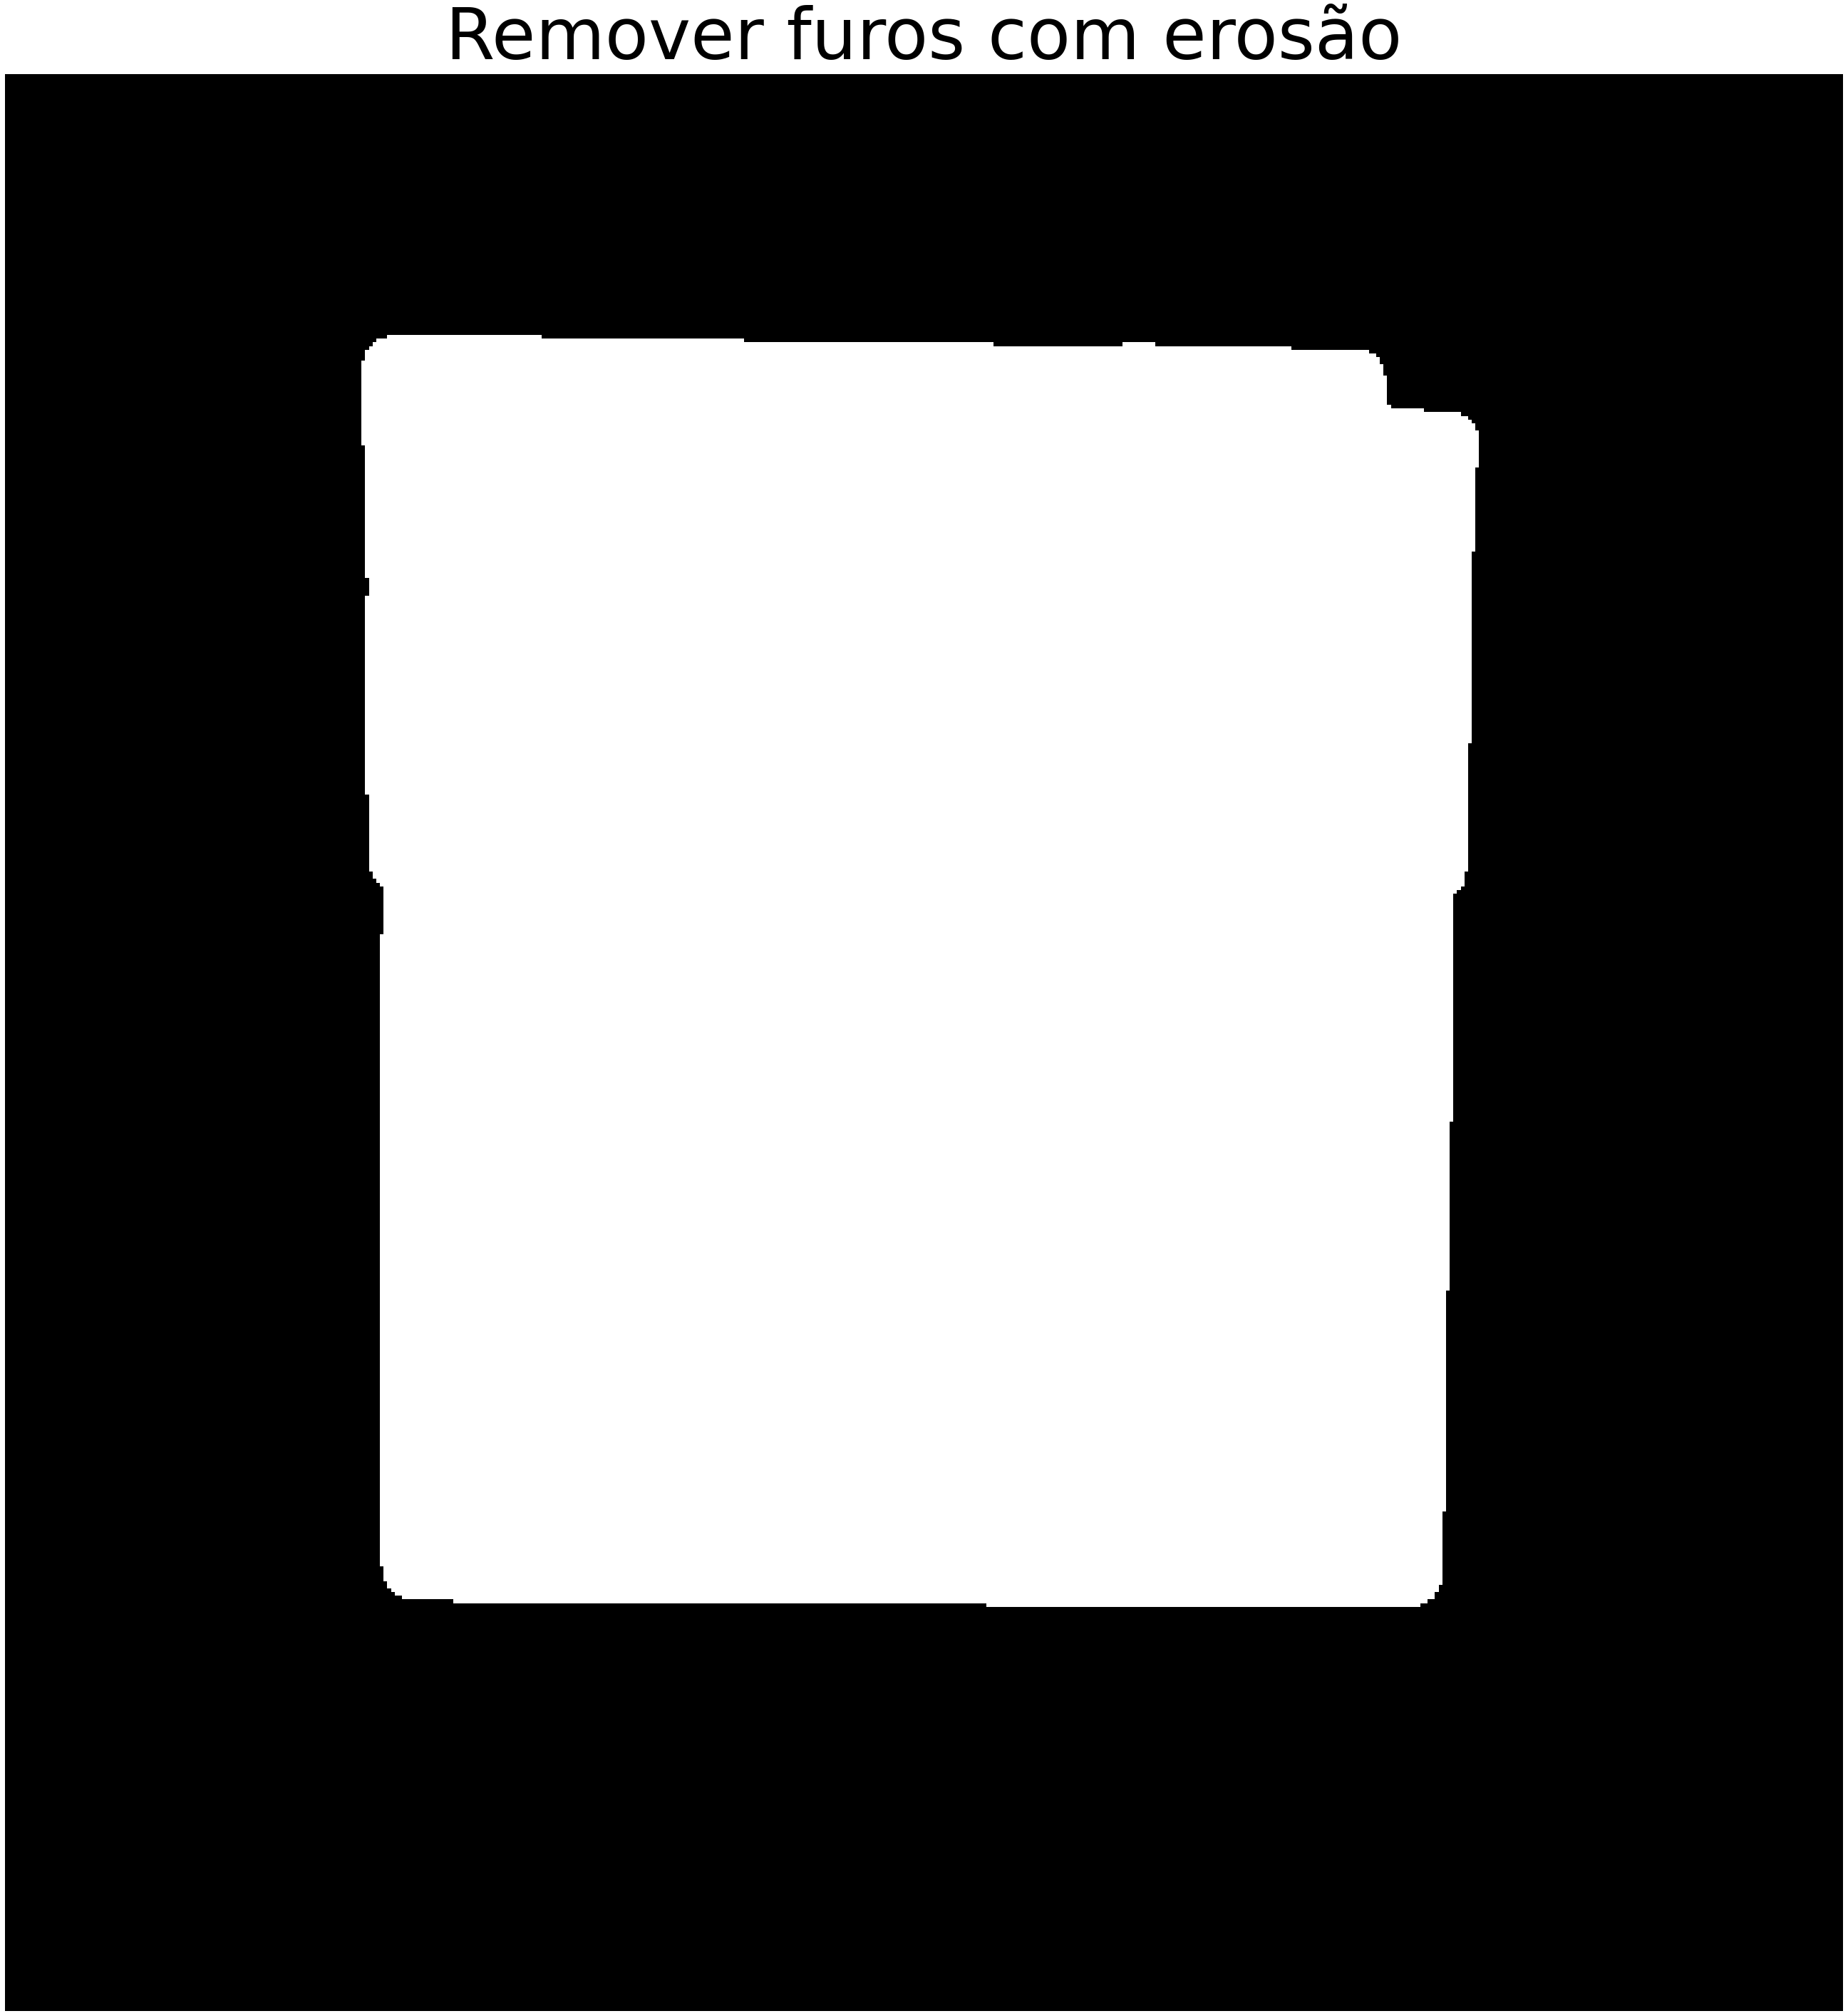

In [3]:
# Carrega a imagem de referência contendo o objeto que queremos detectar e descreva a região do shape
refImage = cv2.imread("imagens/pokemon_red.png")
(_, gameFeatures) = describe_shapes(refImage)

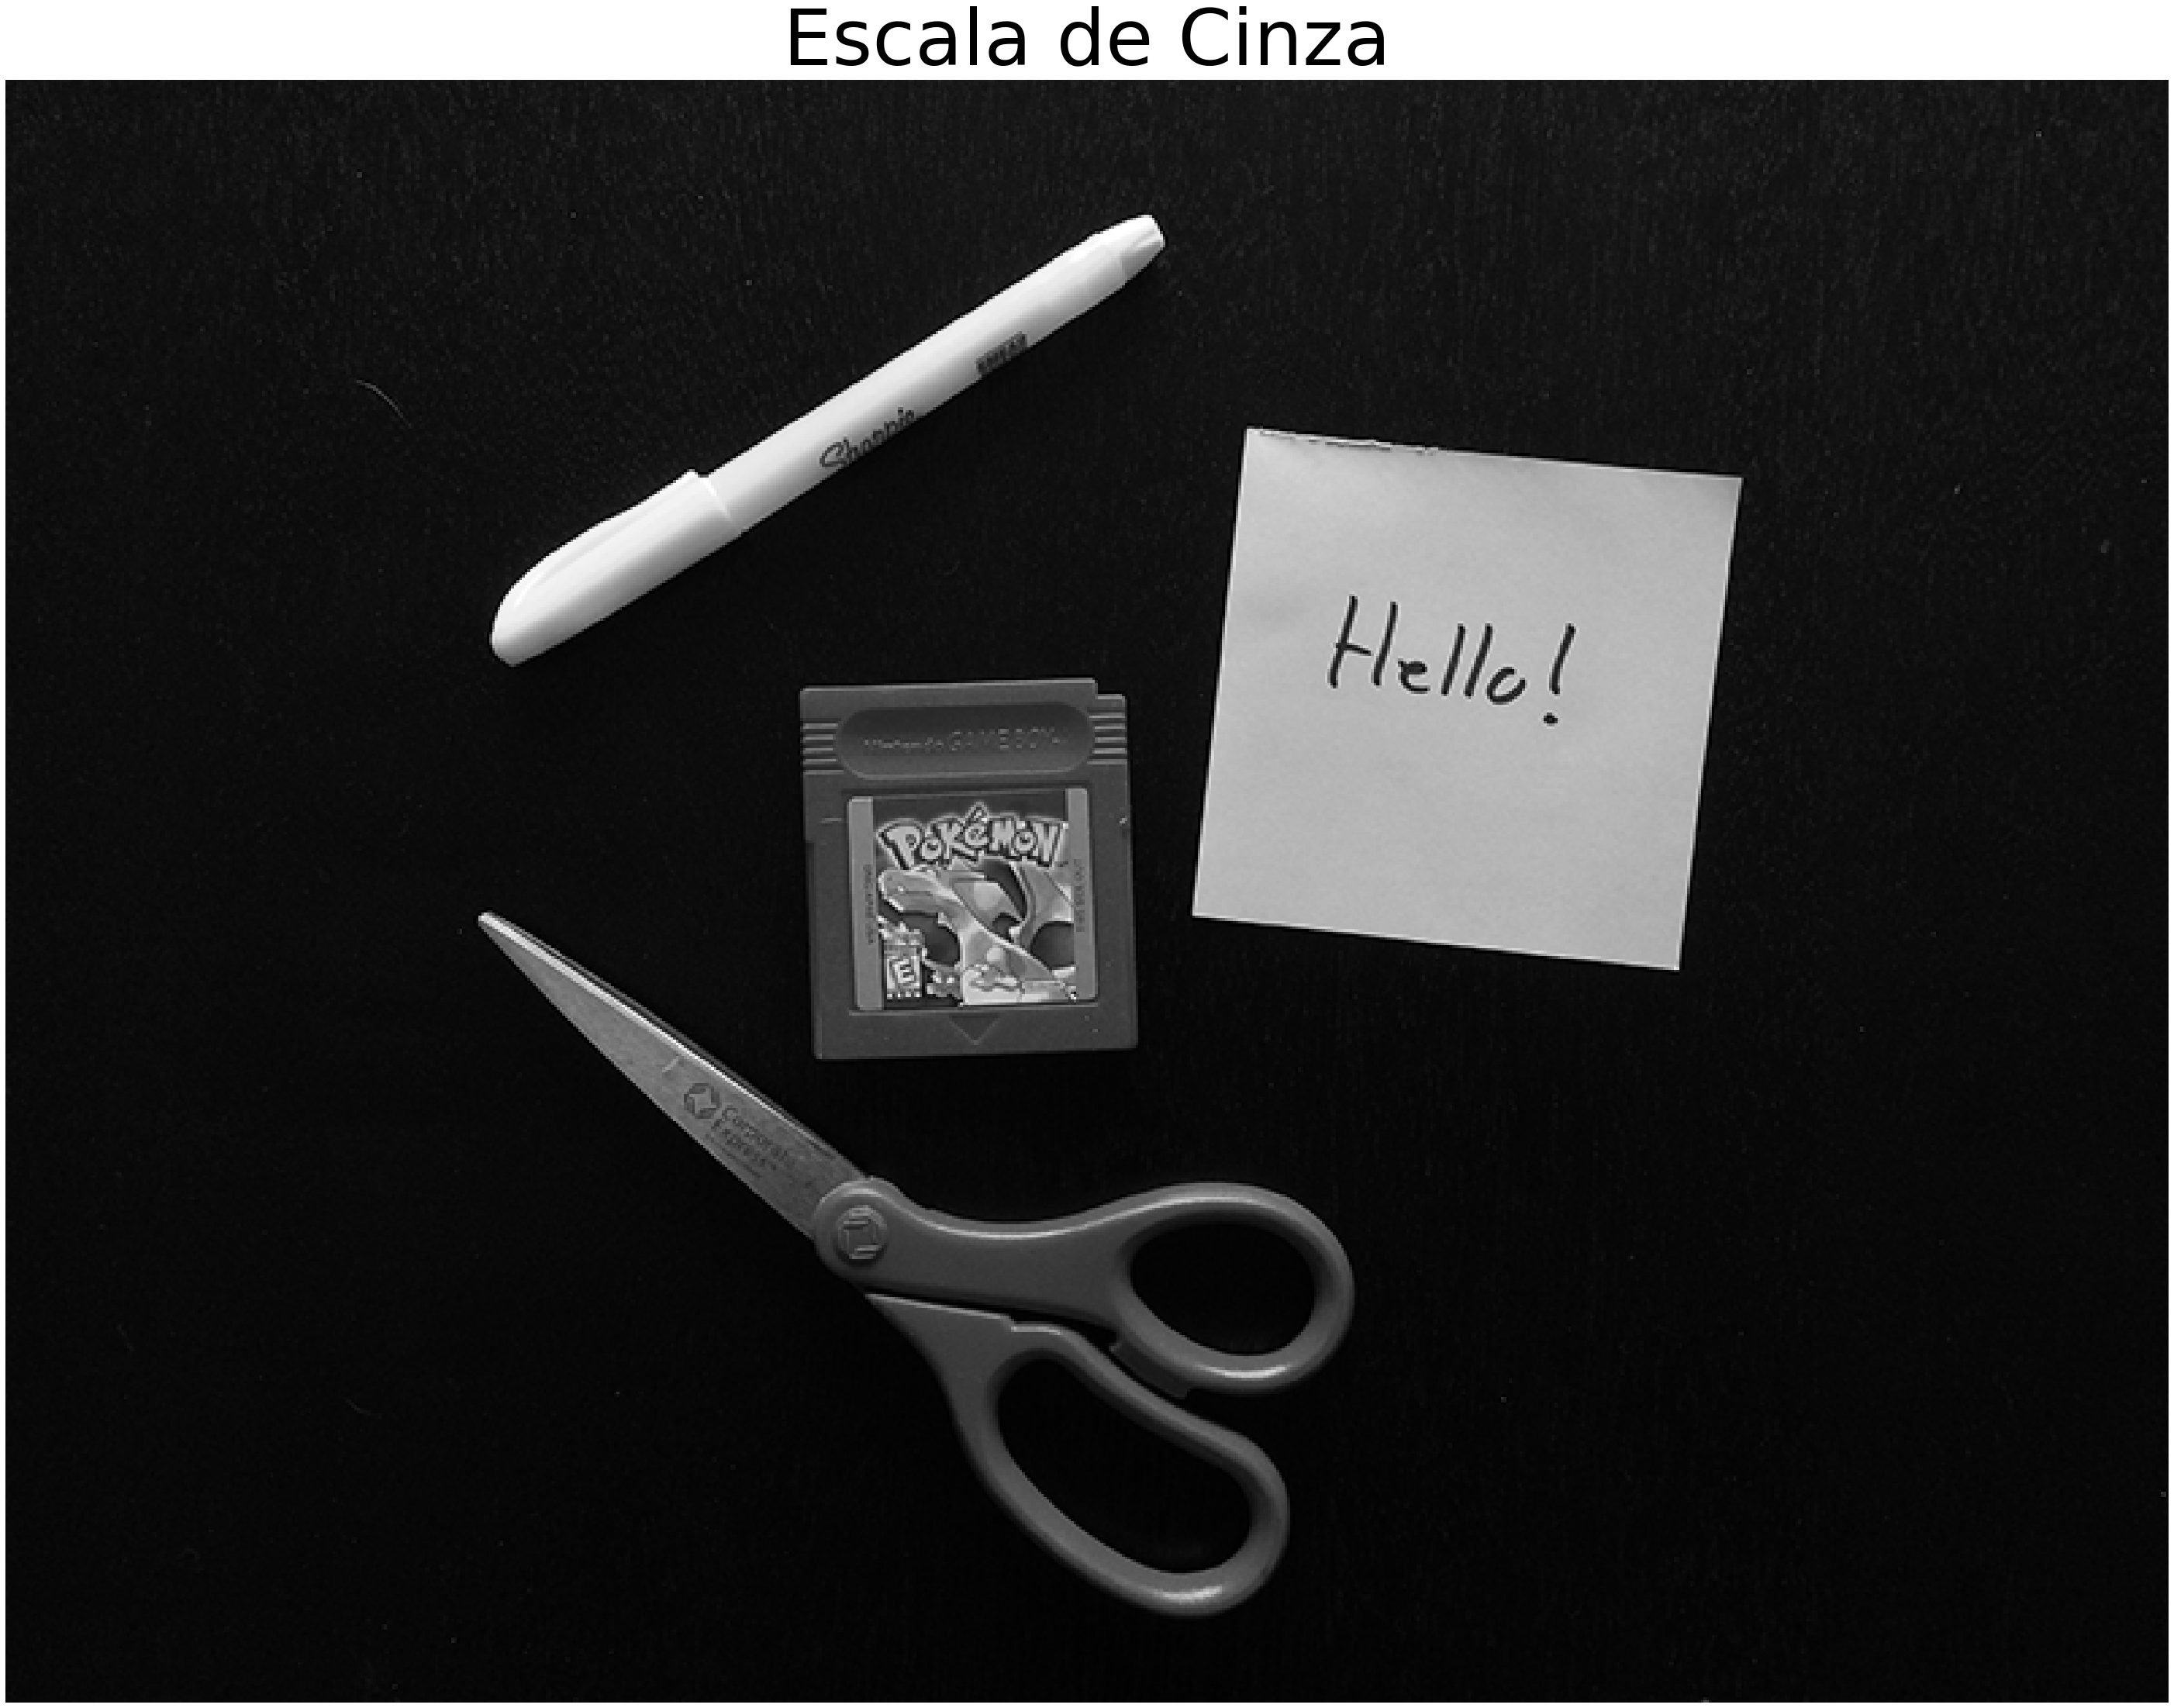

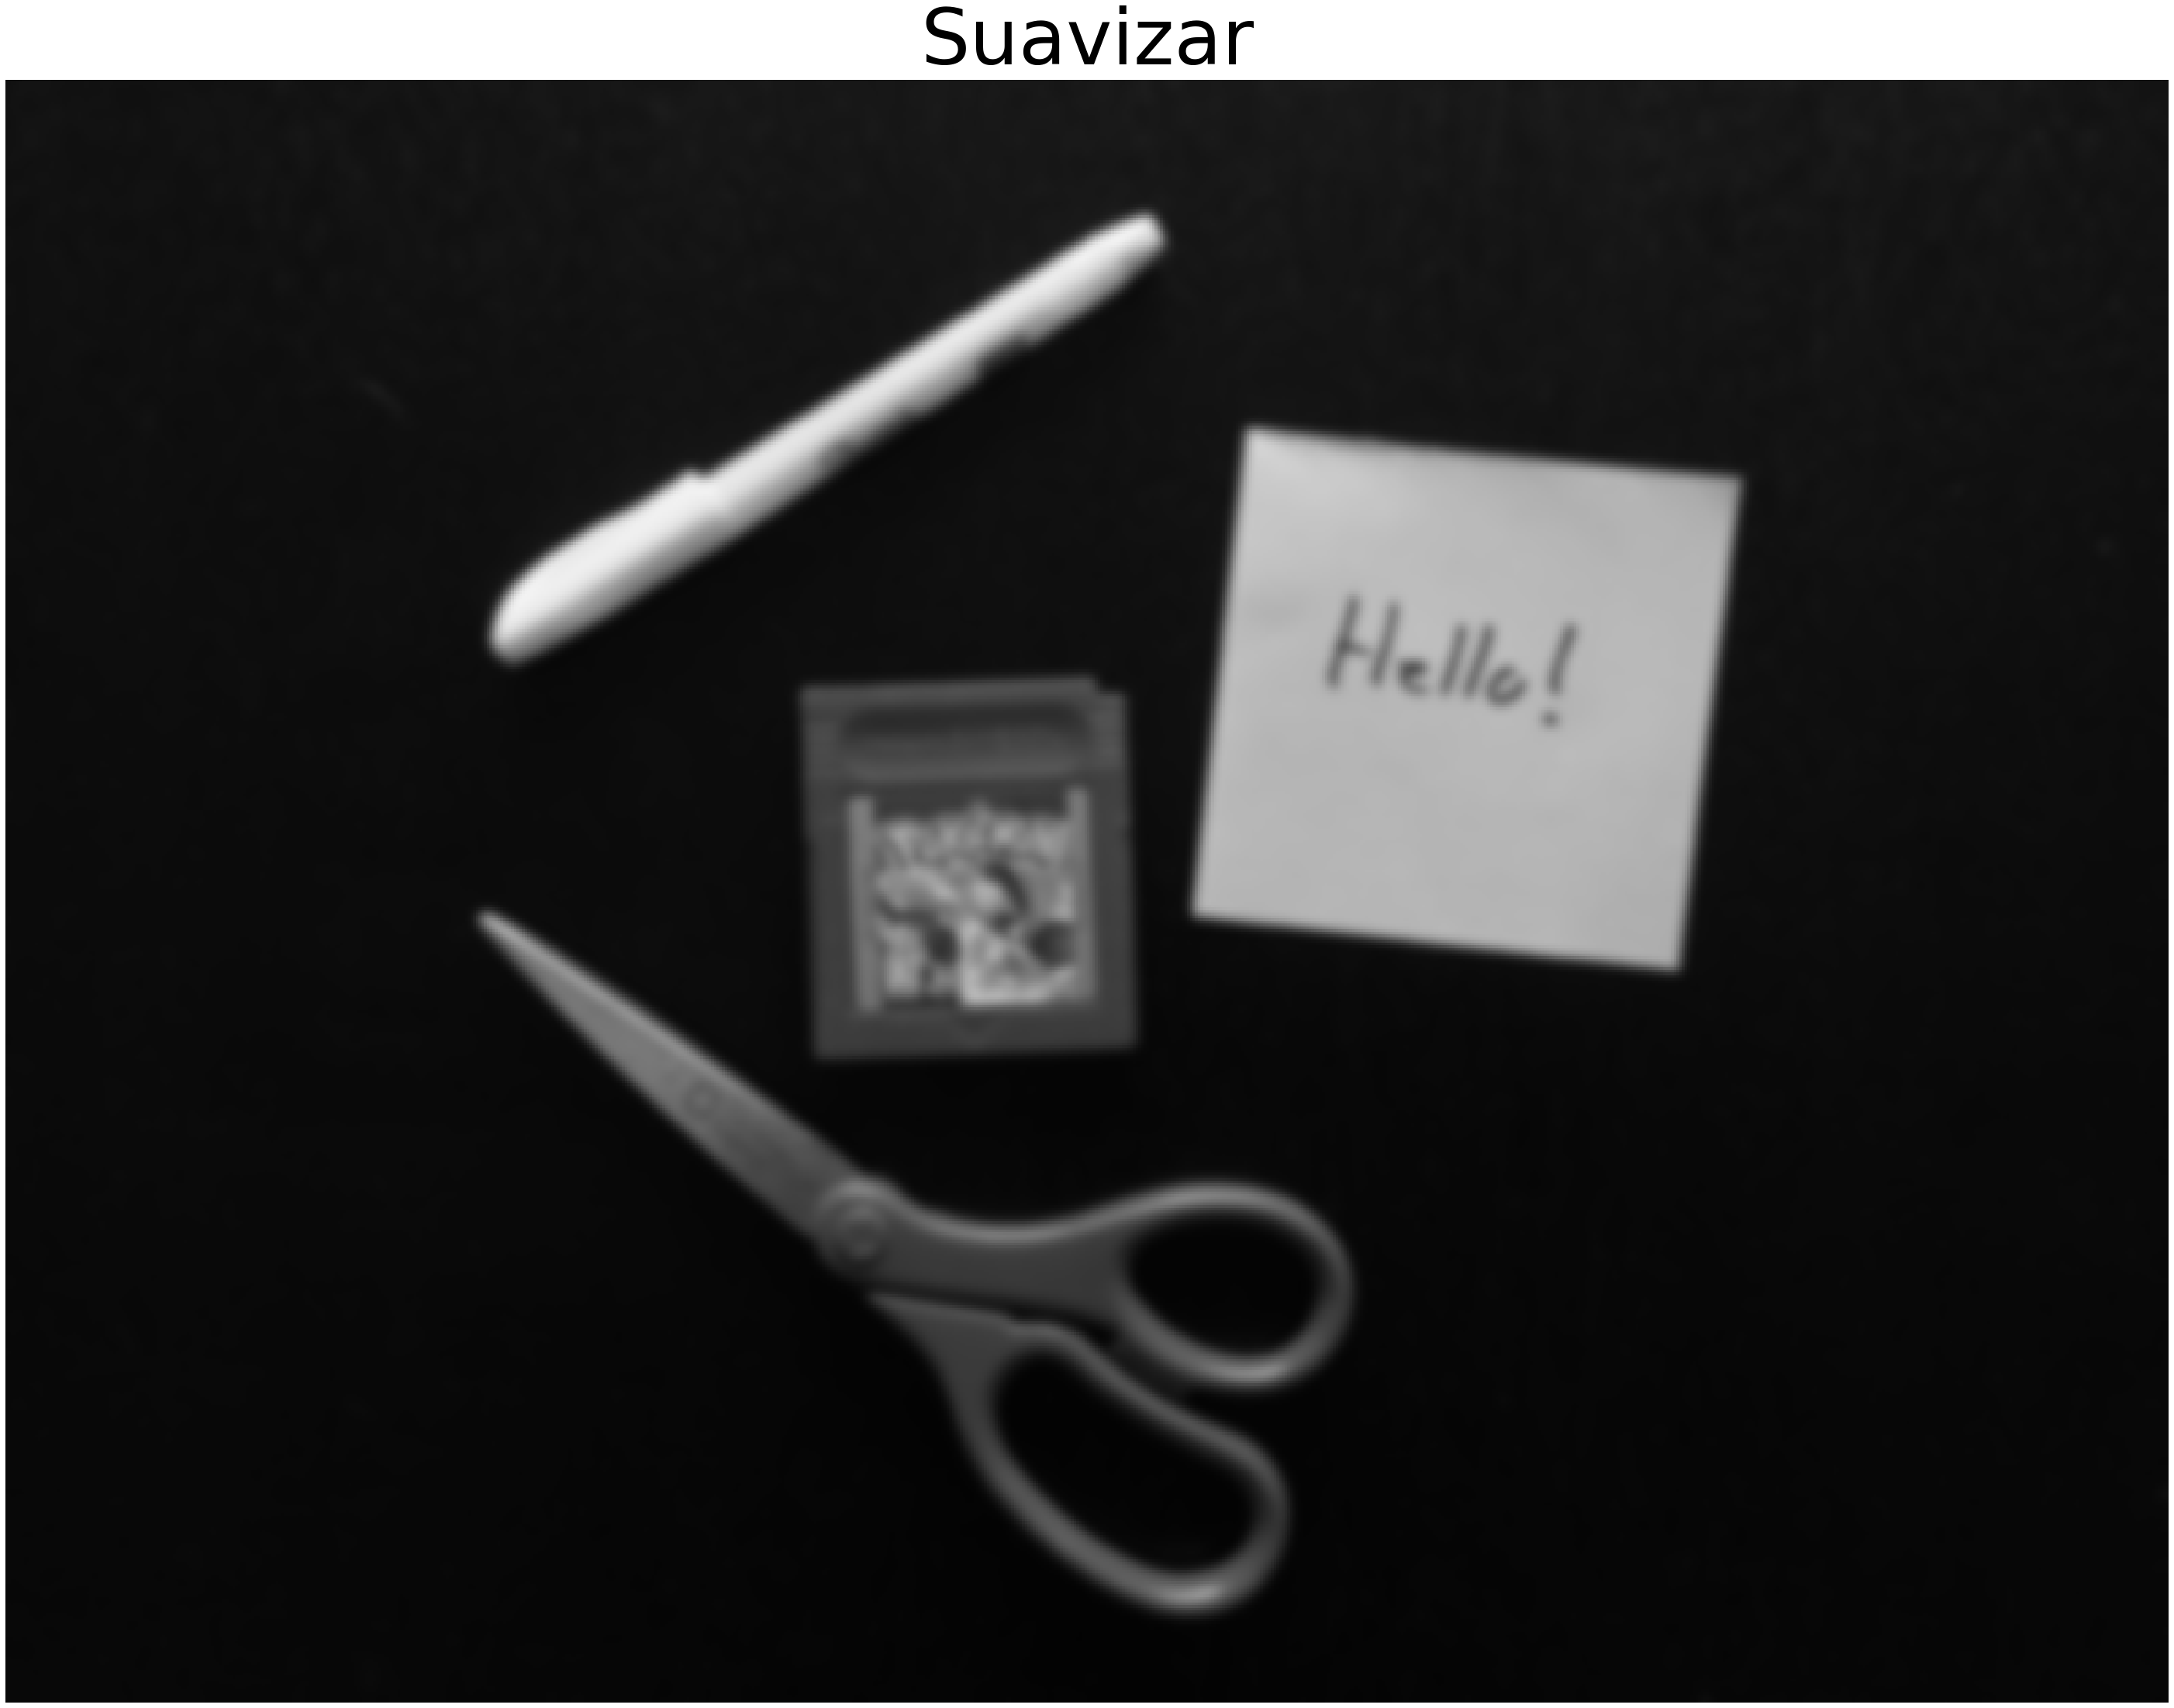

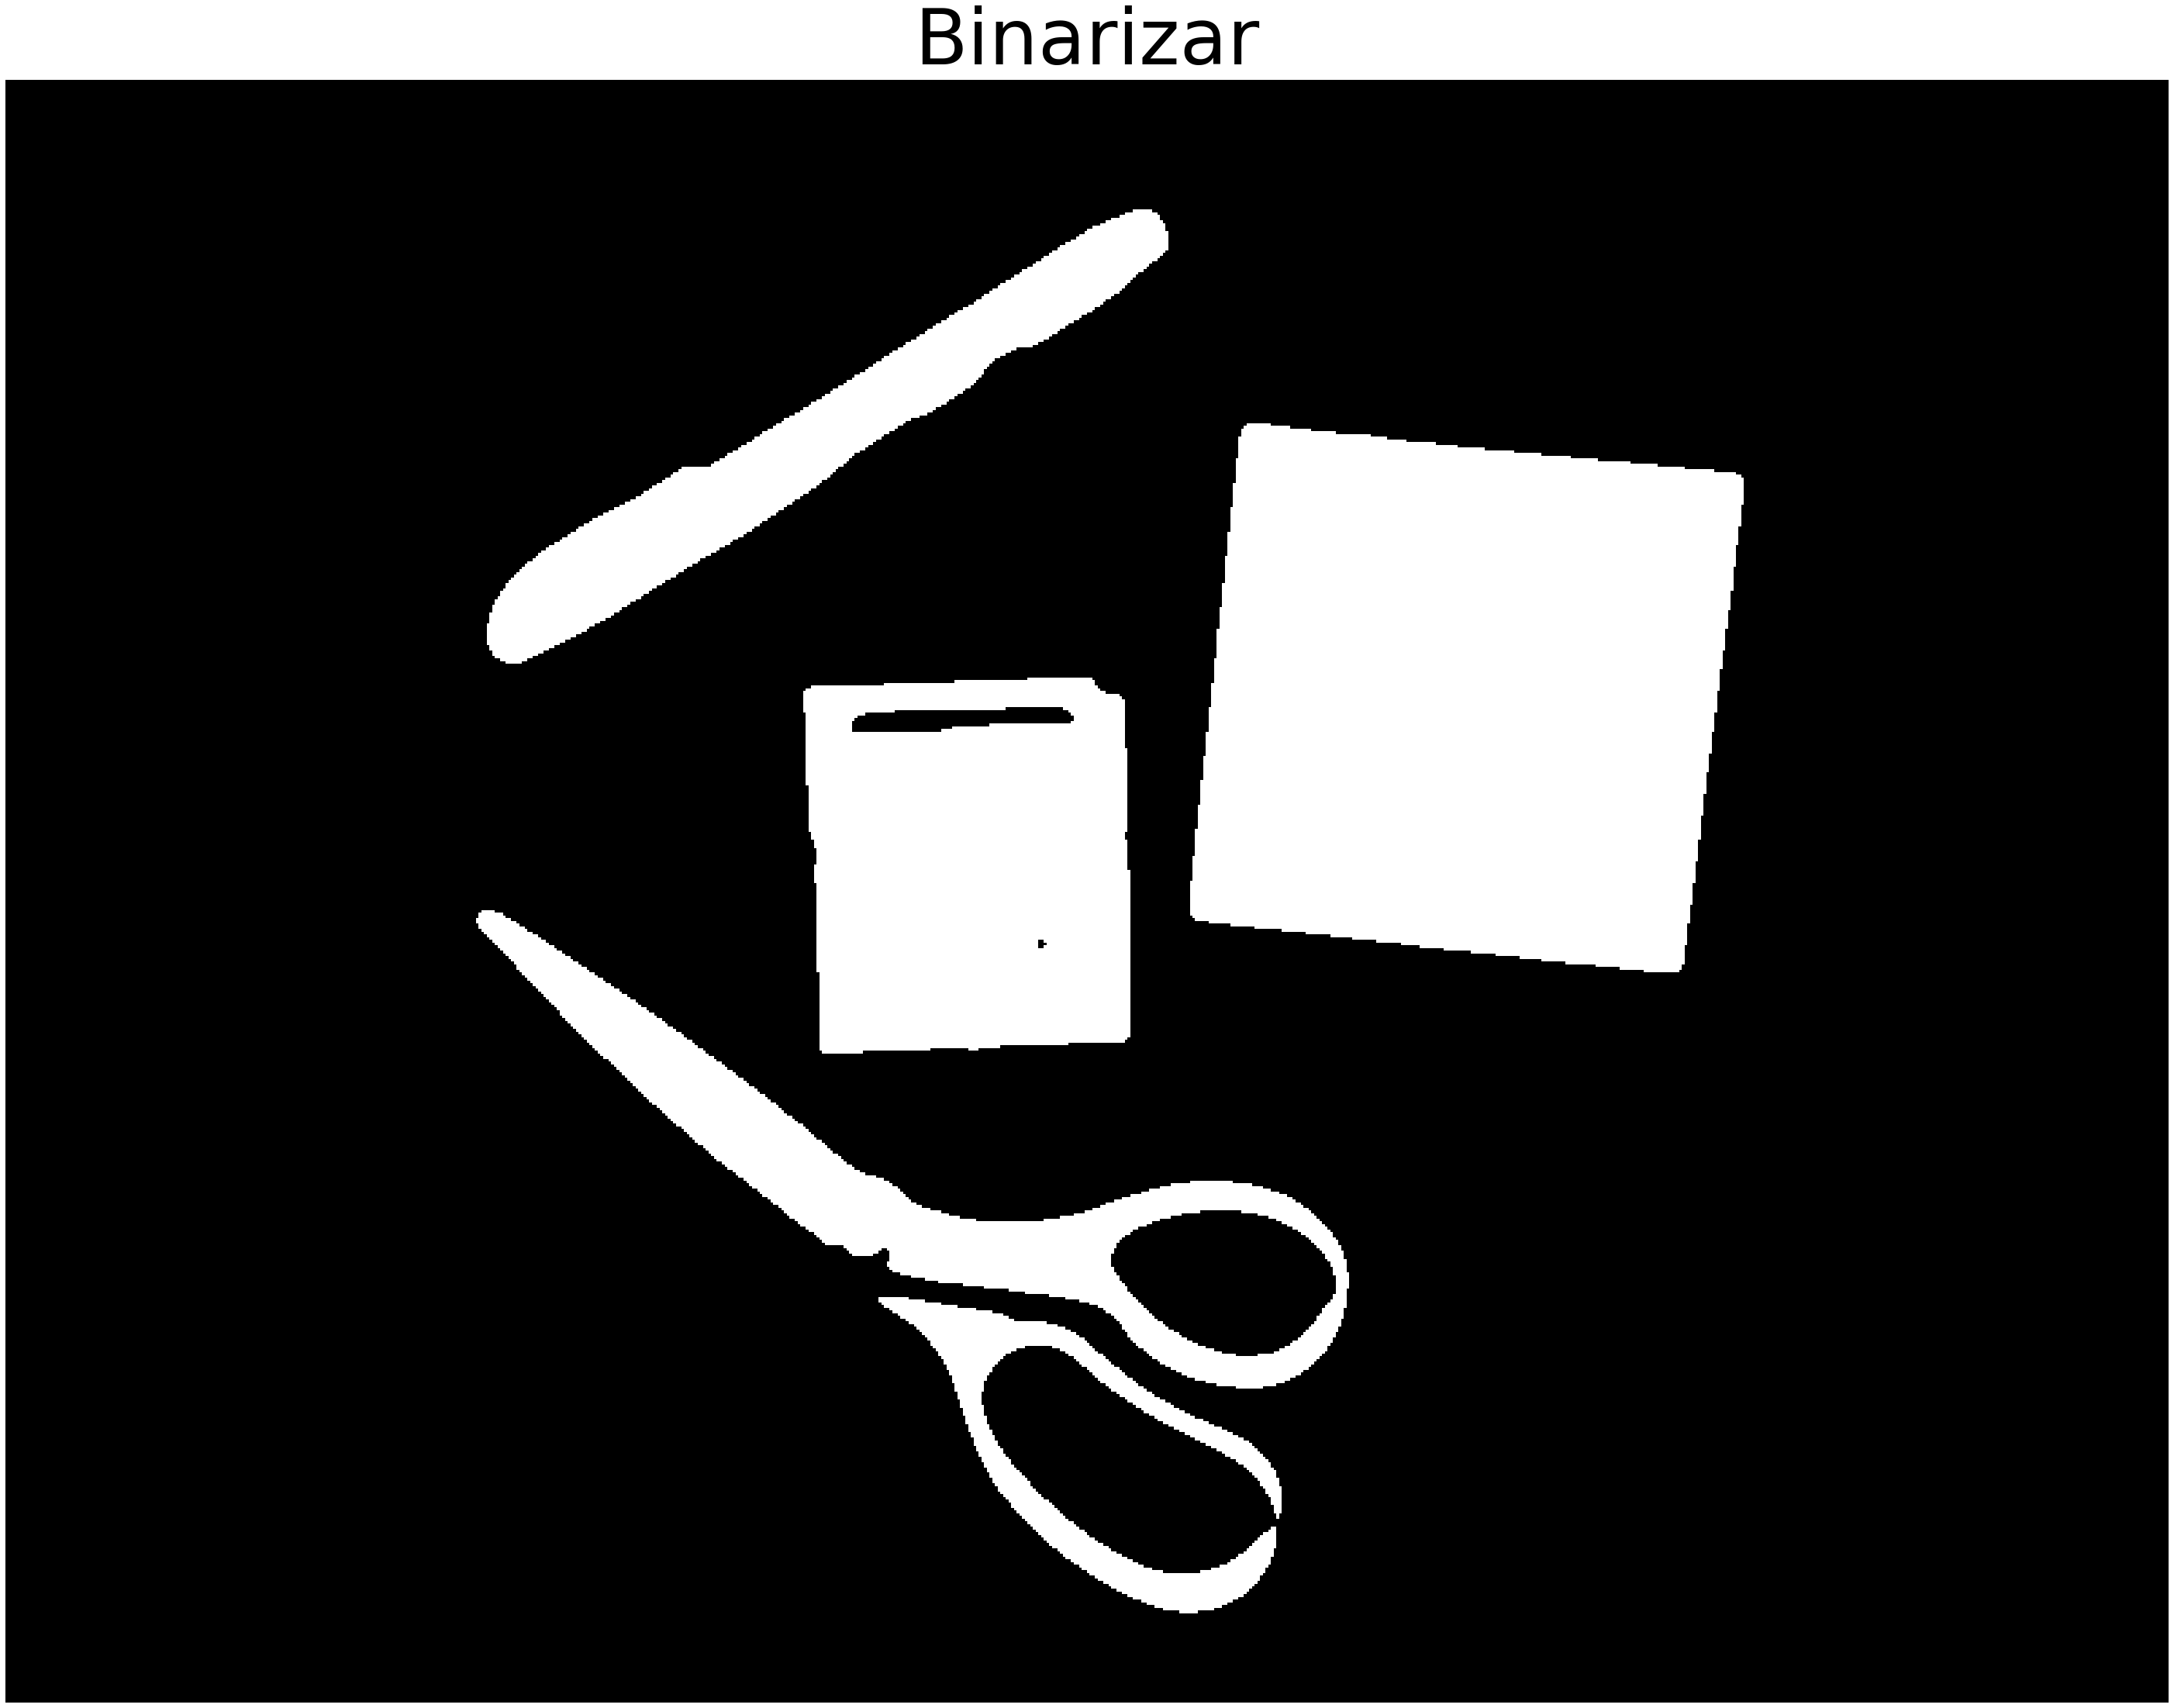

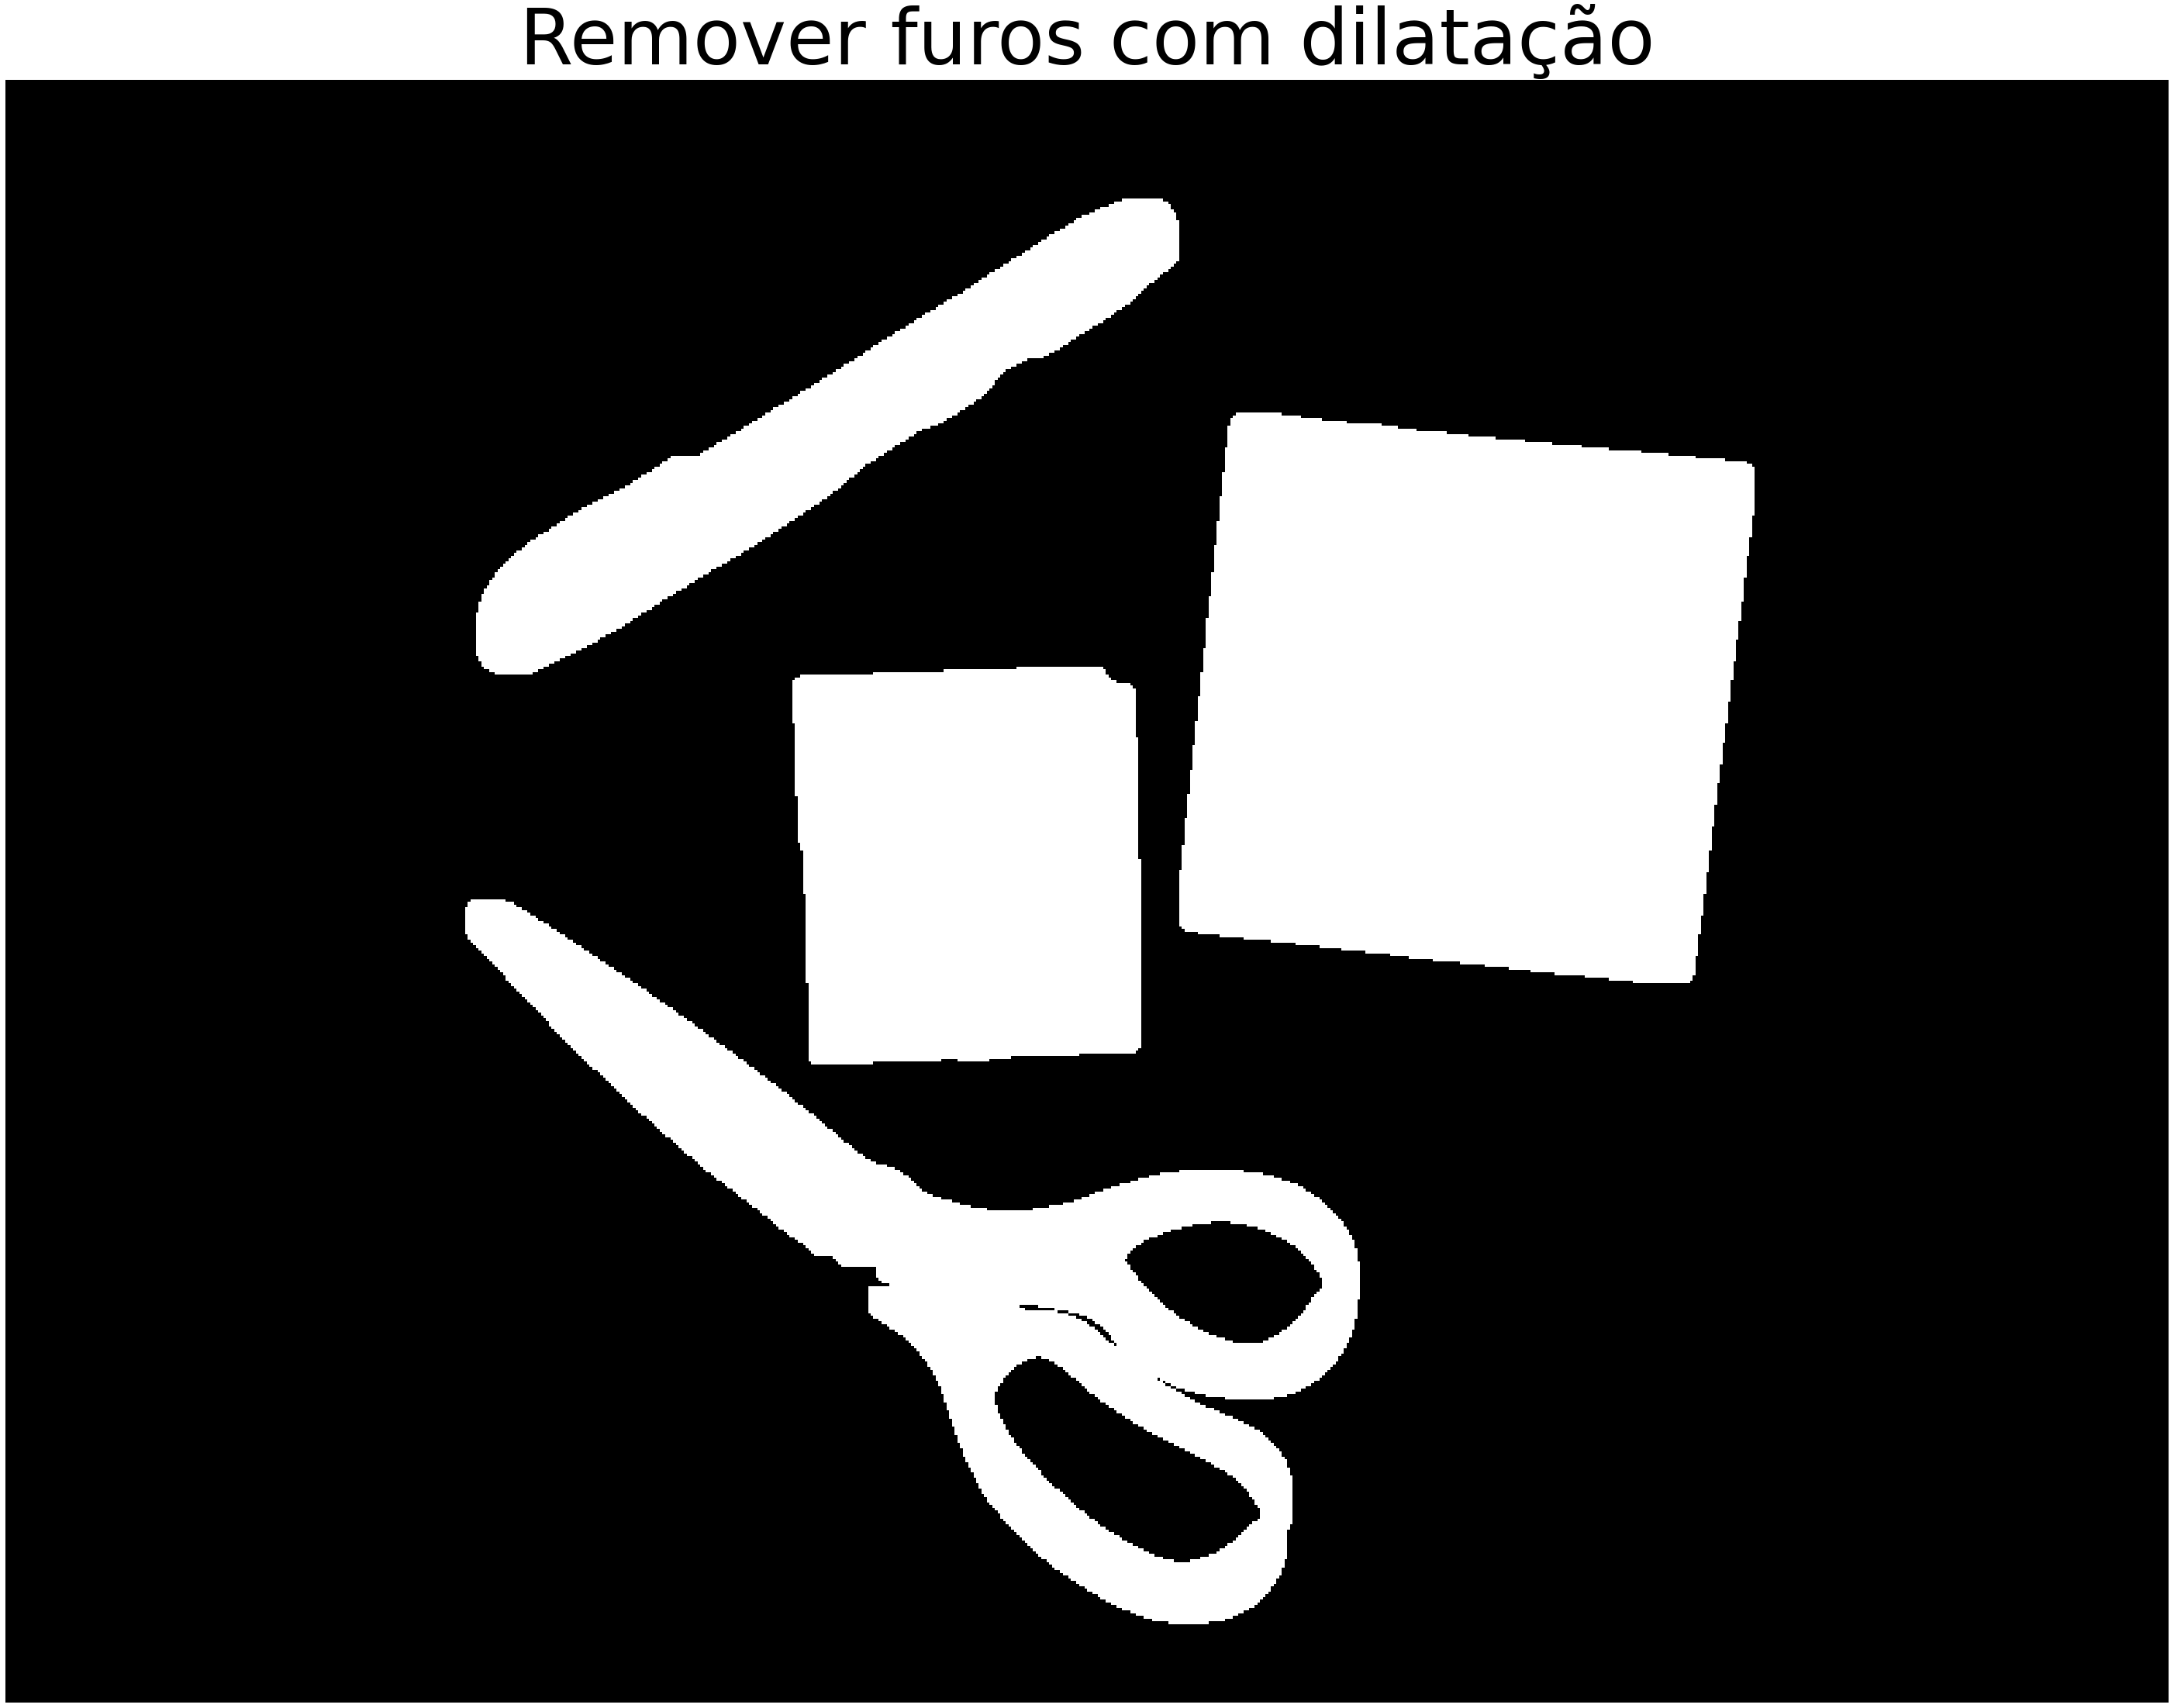

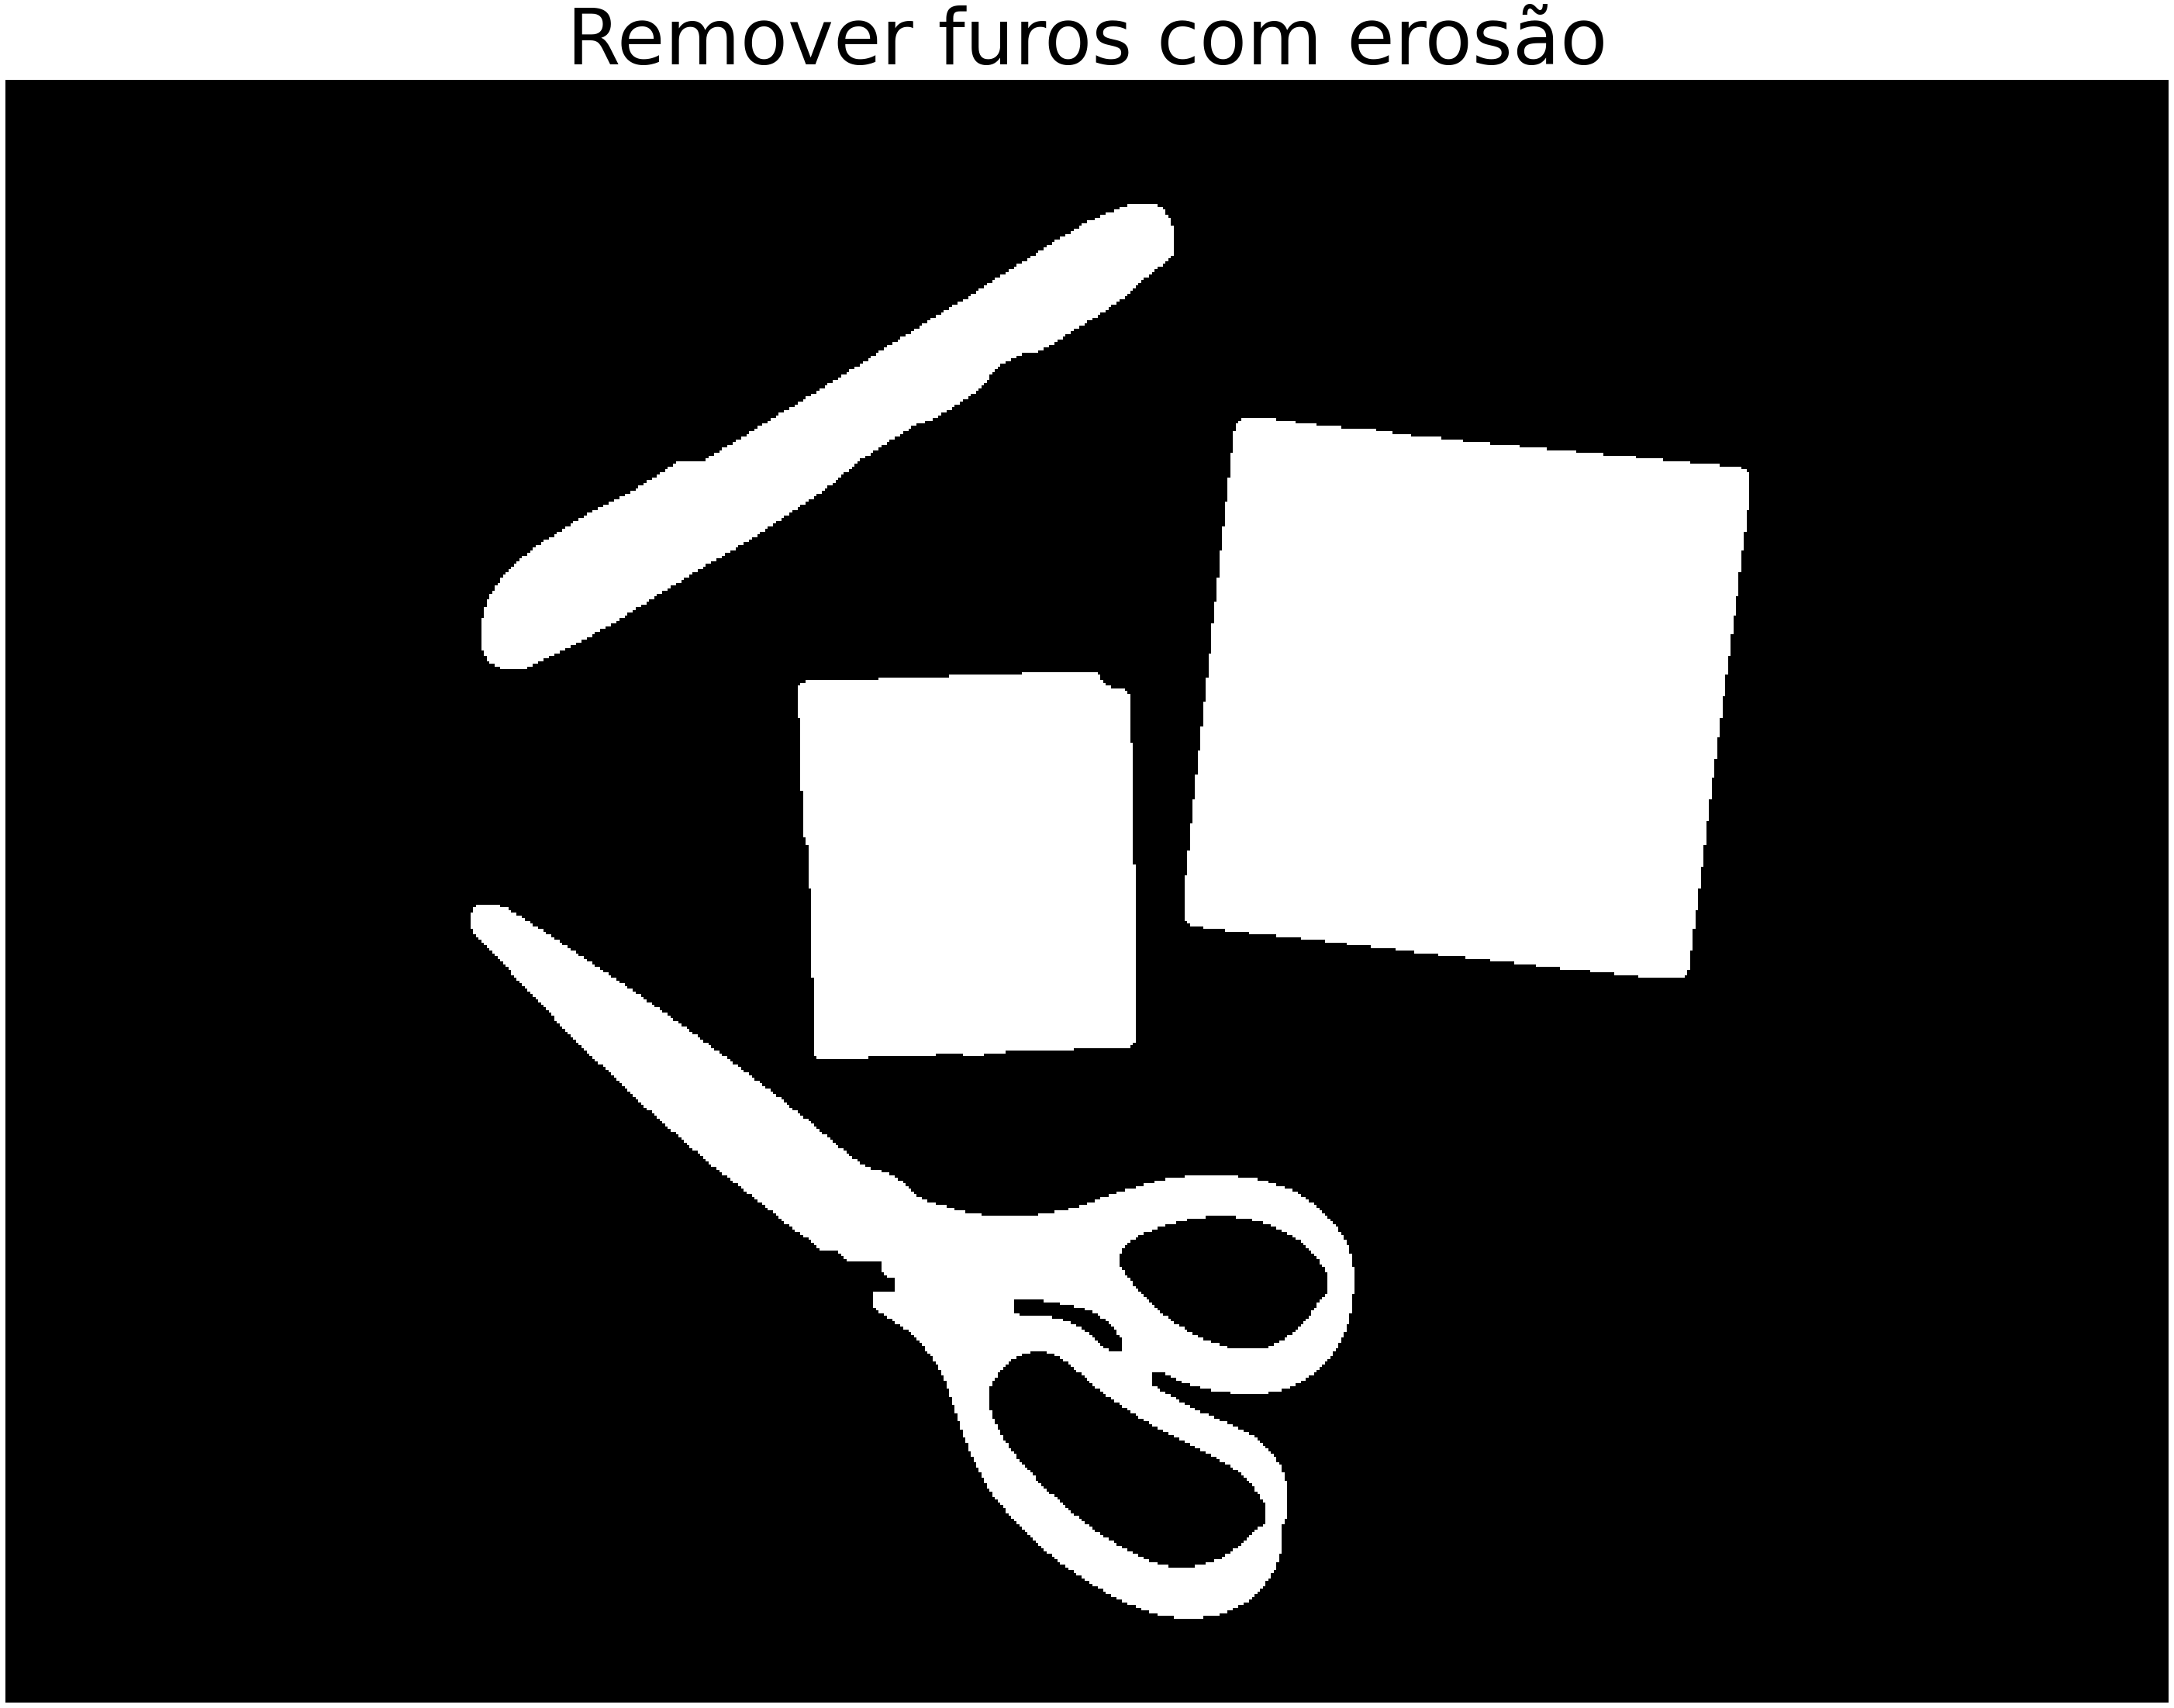

In [4]:
# Carrega os shapes e descreve cada uma dos objetos na imagem
shapesImage = cv2.imread("imagens/shapes.png")
(cnts, shapeFeatures) = describe_shapes(shapesImage)

In [5]:
# Calcula as distâncias euclidianas entre os recursos da imagem do videogame e todas as outras
# formas na segunda imagem, então encontra o índice da menor distância
D = dist.cdist(gameFeatures, shapeFeatures)
i = np.argmin(D)

In [6]:
# Loop sobre todos os contornos do shape da imagem
for (j, c) in enumerate(cnts):
    # Se o índice do contorno atual não for igual ao contorno de índice do contorno com a menor distância, 
    # desenhe-o na imagem de saída
    if i != j:
        box = cv2.minAreaRect(c)
        box = np.int0(cv2.boxPoints(box))
        cv2.drawContours(shapesImage, [box], -1, (0, 0, 255), 2)

In [7]:
# Desenha a caixa delimitadora em torno da forma detectada
box = cv2.minAreaRect(cnts[i])
box = np.int0(cv2.boxPoints(box))
cv2.drawContours(shapesImage, [box], -1, (0, 255, 0), 2)
(x, y, w, h) = cv2.boundingRect(cnts[i])
cv2.putText(shapesImage, "FOUND!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 3)

array([[[17, 19, 16],
        [16, 17, 15],
        [17, 15, 15],
        ...,
        [28, 23, 24],
        [23, 18, 17],
        [22, 15, 12]],

       [[17, 19, 17],
        [17, 17, 17],
        [18, 16, 17],
        ...,
        [25, 20, 22],
        [22, 18, 17],
        [25, 20, 17]],

       [[12, 12, 12],
        [17, 15, 15],
        [15, 13, 13],
        ...,
        [24, 19, 21],
        [24, 19, 20],
        [24, 20, 20]],

       ...,

       [[ 9,  6,  6],
        [10,  7,  7],
        [11, 10, 10],
        ...,
        [ 5,  4,  5],
        [ 5,  5,  5],
        [ 6,  8,  8]],

       [[10,  8,  8],
        [ 9,  7,  7],
        [10,  8,  9],
        ...,
        [ 7,  7,  8],
        [ 6,  8,  8],
        [ 6,  8,  8]],

       [[10,  8,  8],
        [11,  9,  9],
        [ 9,  7,  7],
        ...,
        [ 6,  8, 10],
        [ 5,  7,  8],
        [ 5,  7,  7]]], dtype=uint8)

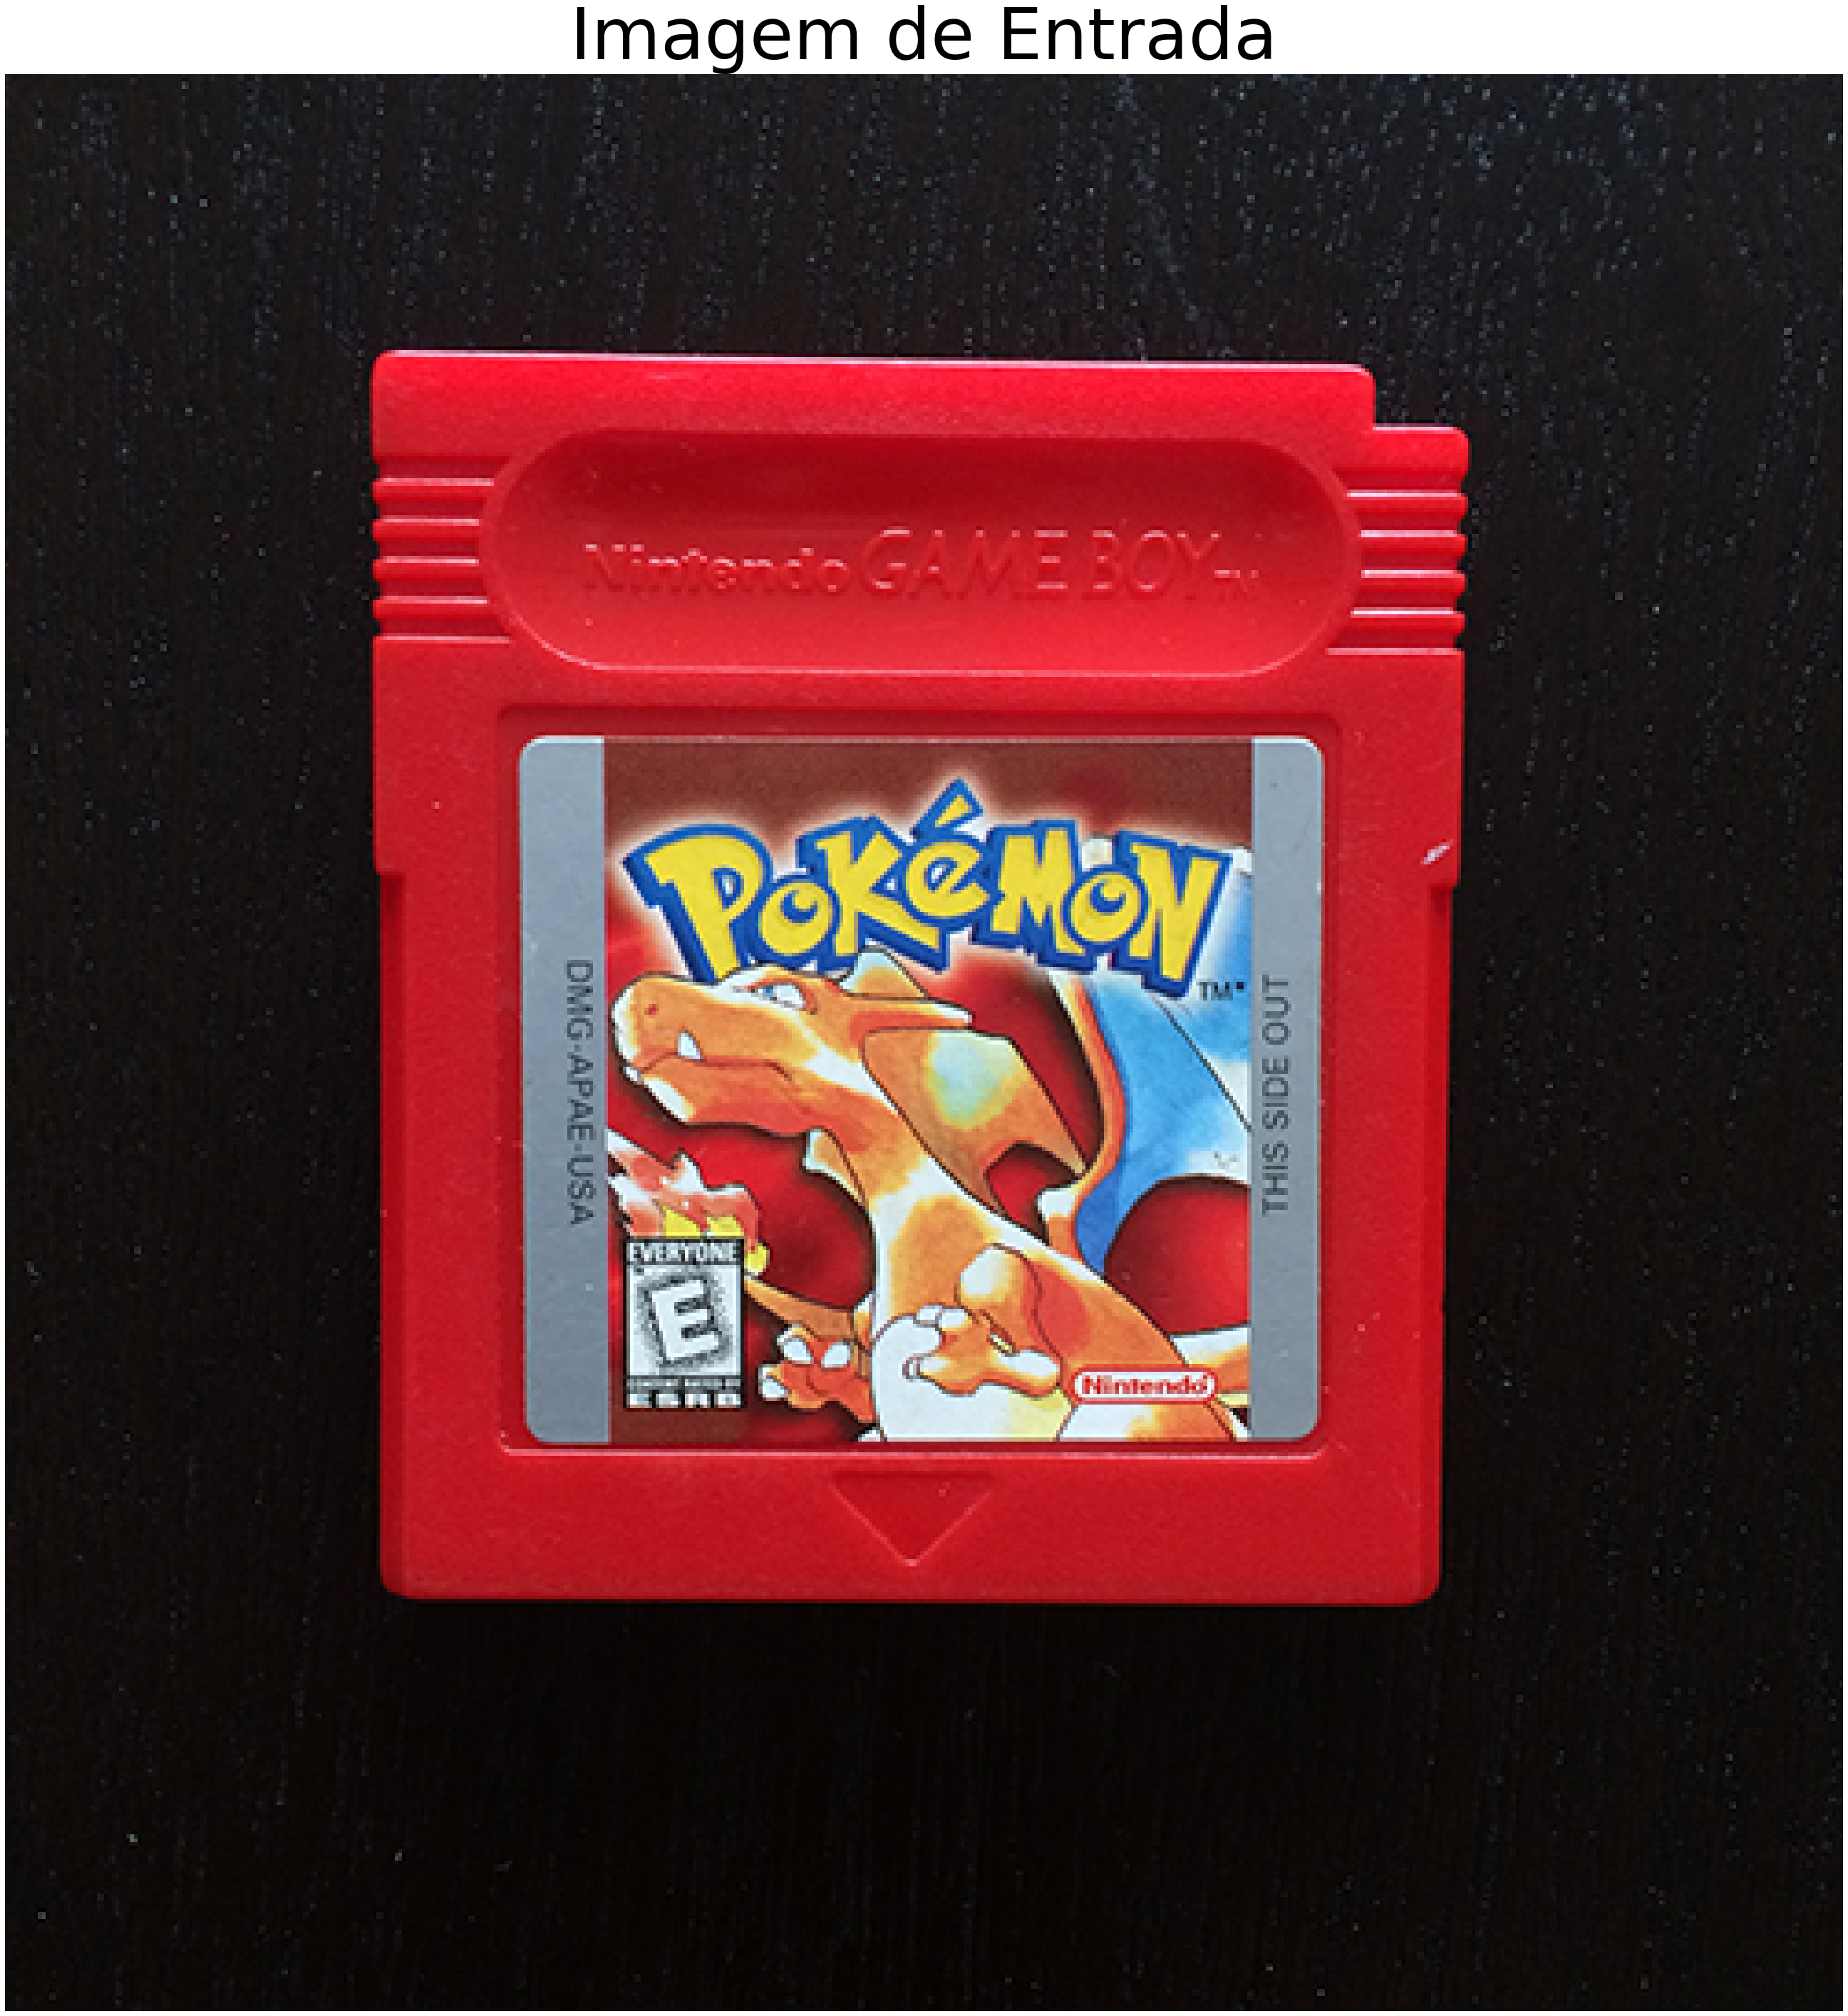

In [8]:
# Output
show(refImage, "Imagem de Entrada")

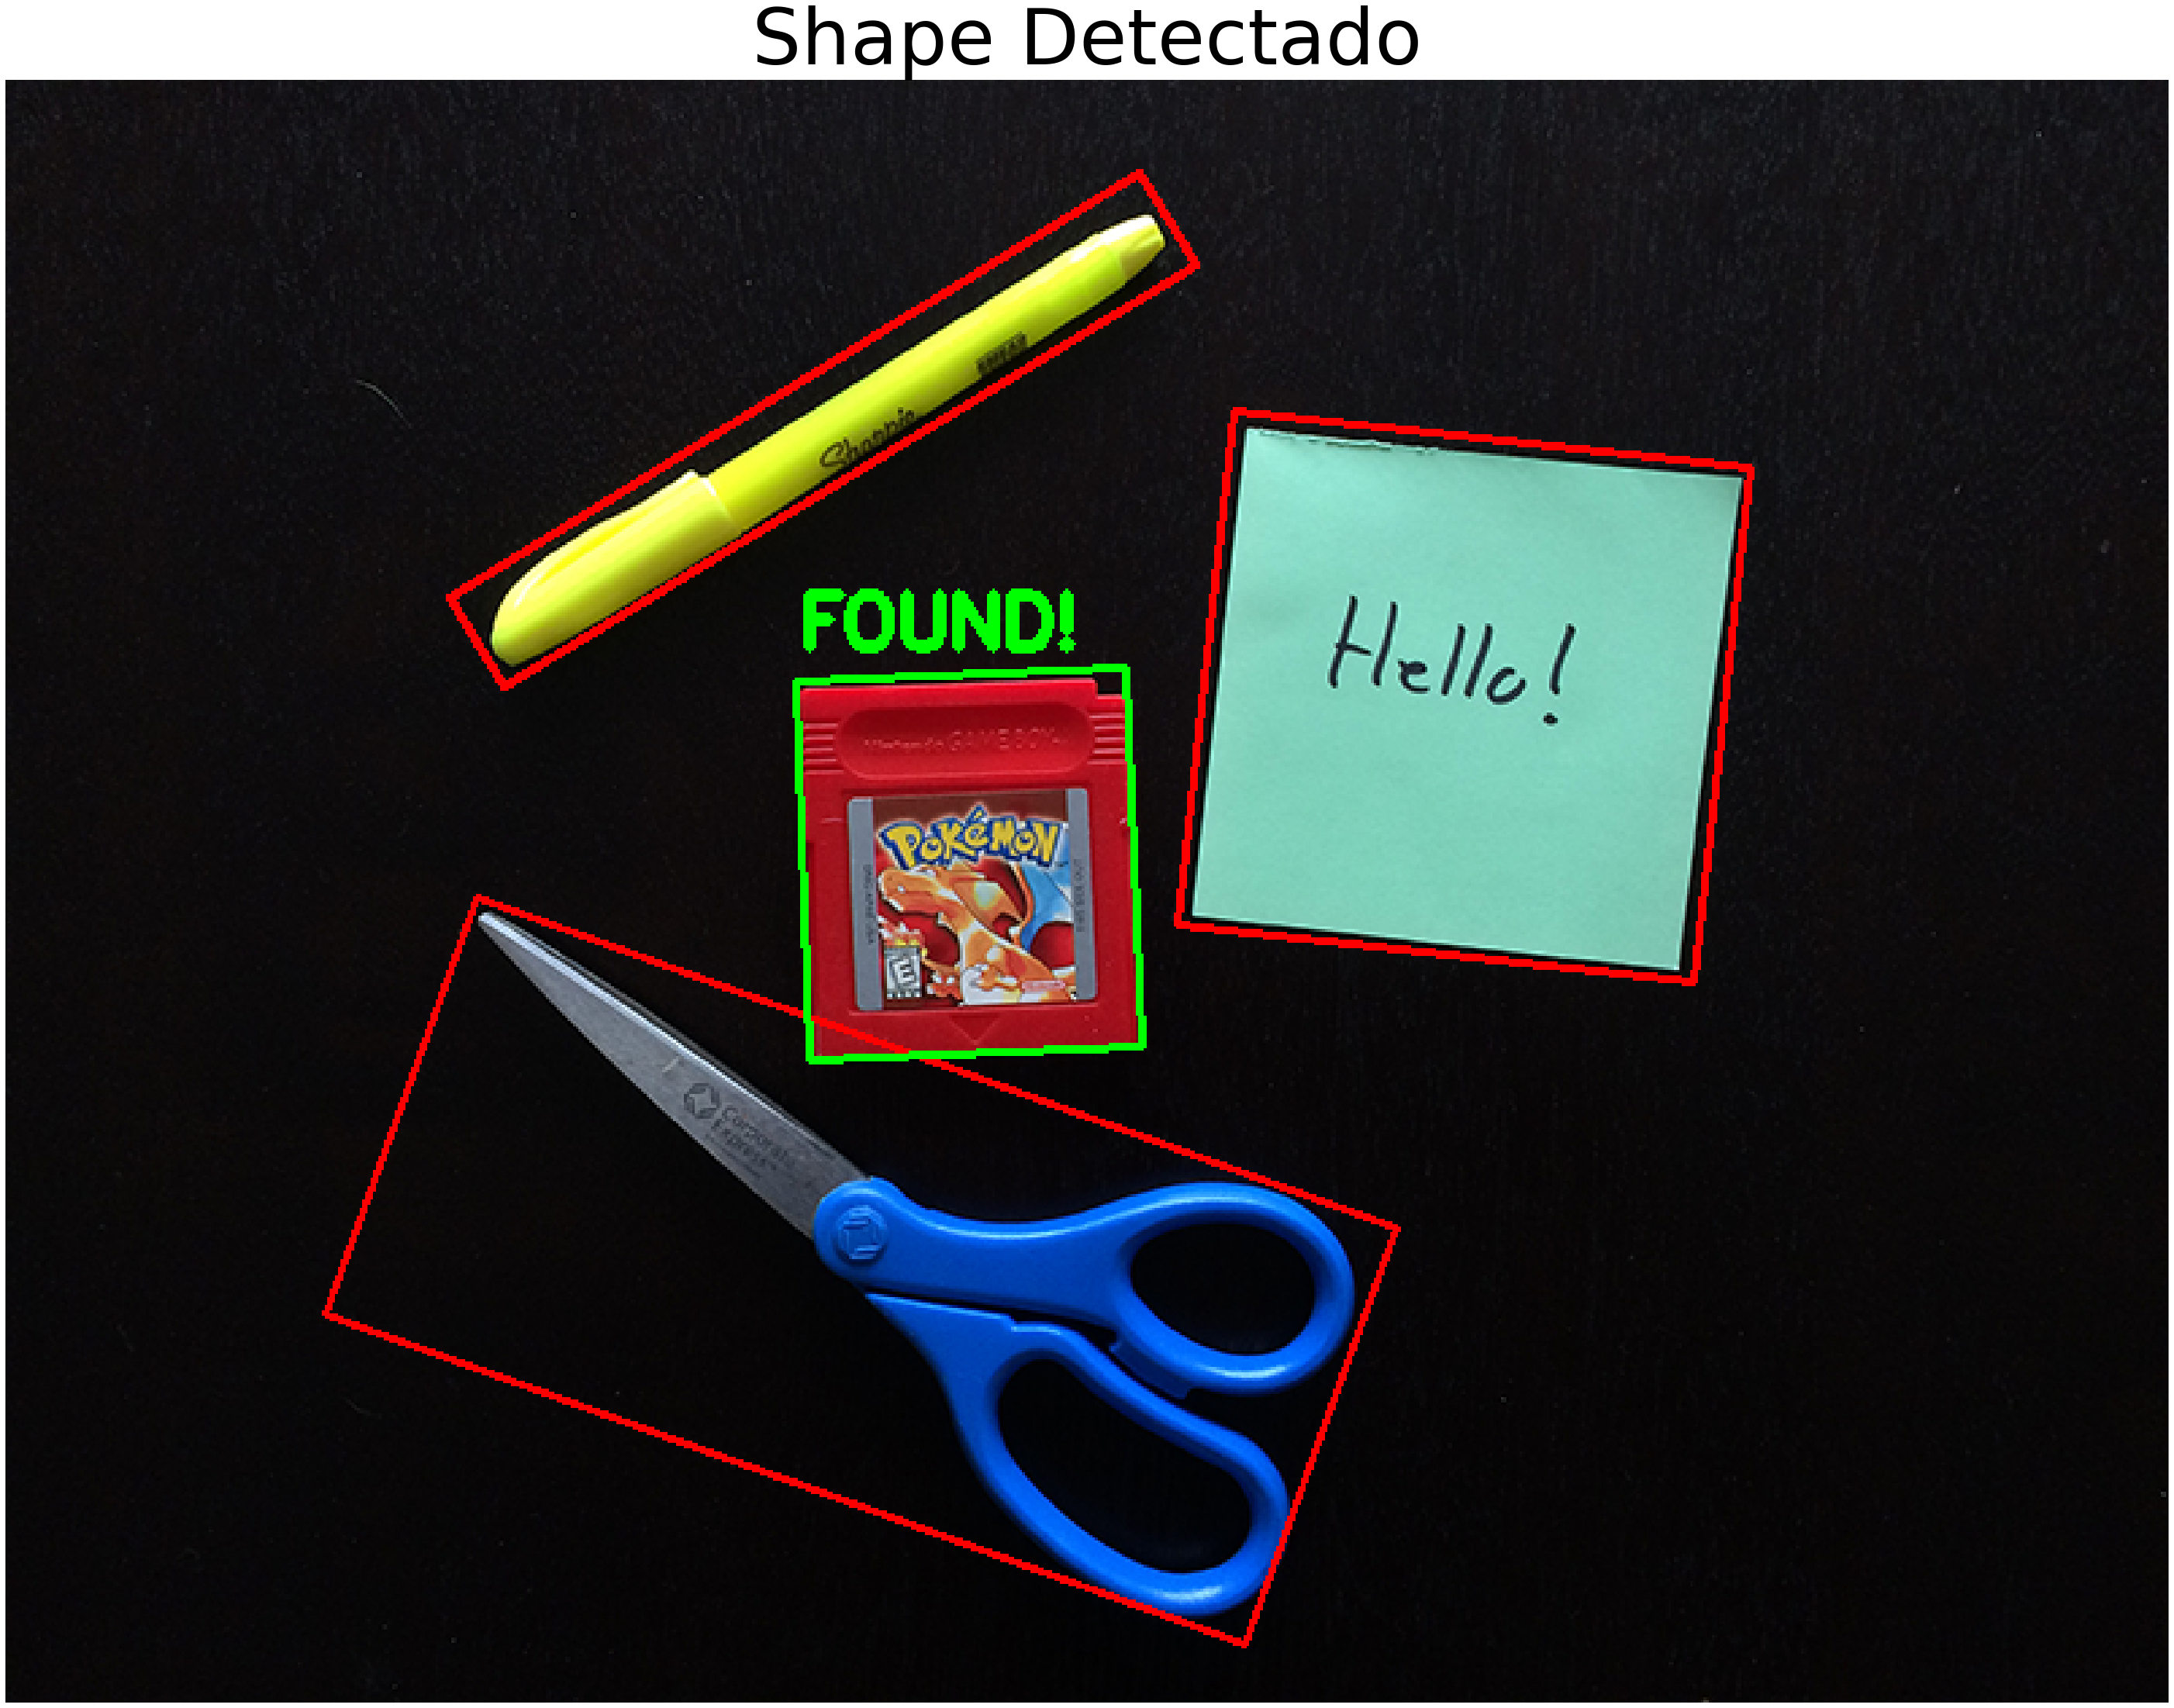

In [9]:
show(shapesImage, "Shape Detectado")